<a href="https://colab.research.google.com/github/p25-c4/plate_project/blob/main/0312_final_ji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf
!pip install xgboost

## 드라이브 마운트

In [111]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns


from sklearn.tree import export_graphviz
import graphviz
from subprocess import call
from IPython.display import Image


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


from statsmodels.api import Logit

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

# 팔레트 설정
palette = sns.color_palette('Paired')
colors = sns.color_palette('Pastel1')
sns.set_palette('Pastel1')

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [113]:
matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False)

## 데이터 구성

In [114]:
df = pd.read_csv("/content/drive/MyDrive/포스코/SCALE불량.csv", encoding = 'euc_kr')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


## 데이터 전처리

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

### 목적 변수

In [116]:
# df['scale'] = df['scale'].map(lambda x : 0 if x == "양품" else 1)
# df.head()

### 명목형 변수

#### rolling_date

*  7-19시를 주간, 19-7시를 야간으로 변환

In [117]:
# rolling_date 열을 datetime 객체로 변환
df['rolling_date'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S')

def transform_date(row):
    hour = row.hour
    if 7 <= hour < 19: return "주간"
    else: return "야간"

# '주간', '야간'으로 변경하면서 day_yn이라는 열 이름 새로 부여
df['day_yn'] = df['rolling_date'].apply(transform_date)
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,day_yn
0,PLT_1001,2023-01-03 07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,116,1133,59,259,1133,TMCP(온도제어),934,8,1조,주간
1,PLT_1002,2023-01-03 07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,122,1135,53,238,1135,TMCP(온도제어),937,8,1조,주간
2,PLT_1003,2023-01-03 07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,116,1121,55,258,1121,TMCP(온도제어),889,8,1조,주간
3,PLT_1004,2023-01-03 07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,125,1127,68,266,1127,TMCP(온도제어),885,8,1조,주간
4,PLT_1005,2023-01-03 07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,134,1128,48,246,1128,TMCP(온도제어),873,8,1조,주간


In [118]:
# 파생변수 day_yn 생성 후 rolling_date 삭제
df.drop(columns='rolling_date',inplace=True)

#### spec_long

<Axes: xlabel='spec_long', ylabel='count'>

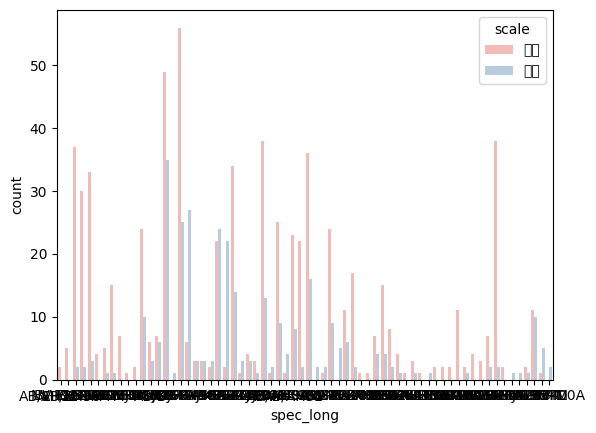

In [119]:
sns.countplot(x='spec_long', hue = 'scale', data = df)



*   그래프에 불량갯수가 더 많은 품목들도 있음
*   제품 규격의 종류가 많아서 어떤 제품 규격인지 보이지 않는 문제 발생
*   양품과 불량 제품을 따로 목록으로 출력해보기


In [120]:
# 양품보다 불량이 더 많은 후판 규격.
grouped = df.groupby(['spec_long', 'scale']).size().unstack(fill_value=0)
bad_more_than_good = grouped[grouped['불량'] > grouped['양품']].index.tolist()
bad_more_than_good

['A131-DH36TM',
 'A283-C',
 'A516-60',
 'BV-AH36-TM',
 'CCS-B',
 'JS-SM400A',
 'JS-SM490A',
 'JS-SM490YA',
 'JS-SS400',
 'KR-A',
 'KR-B',
 'KS-SM400A',
 'KS-SM490A',
 'KS-SS400',
 'LR-EH32-TM',
 'NV-B']

*  불량이 더 많은 규격의 특징을 파악해볼 수 있음

#### spec_country

<Axes: xlabel='spec_country', ylabel='count'>

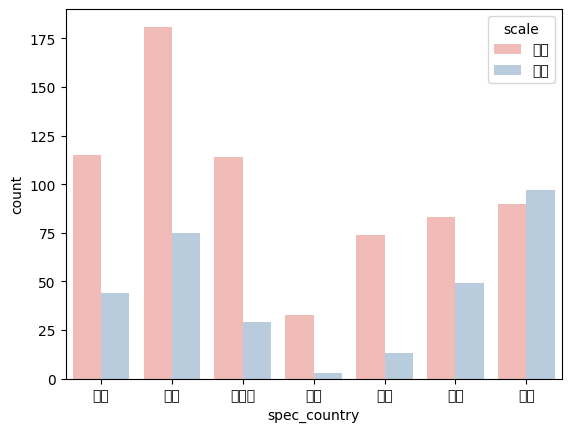

In [121]:
# 나라 규격에 따른 후판 불량 갯수 확인
sns.countplot(x='spec_country', hue = 'scale', data = df)

*   일본 규격으로 만들어진 후판은 불량품이 더 많음
*   불량으로 만들어진 특정 두께, 폭, 길이가 있는지 파악해볼 수 있음


#### plate_no

*  고유값인 plate_no는 삭제

In [122]:
df.drop("plate_no", axis = 1, inplace = True)

#### steel_kind

<Axes: xlabel='steel_kind', ylabel='count'>

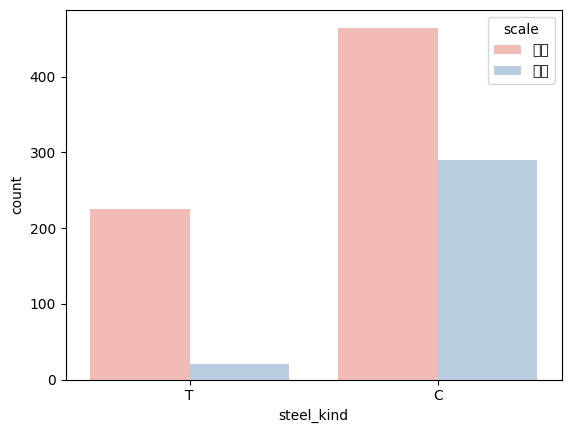

In [123]:
# 강종별 Scale 유무 관계
sns.countplot(x='steel_kind', hue = 'scale', data = df)

*   탄소강(C)이 티타늄강(T)보다 훨씬 불량률이 높음
*   이유: 티타늄이 들어가면 철이 산소랑 반응을 못하게 막음

#### hsb

<Axes: xlabel='hsb', ylabel='Count'>

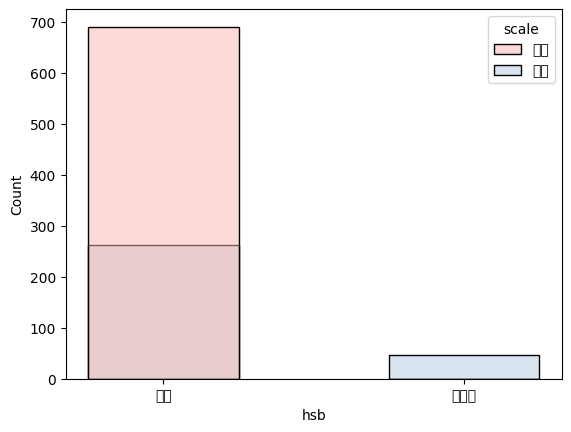

In [124]:
# HSB 적용에 따른 후판 분포 확인
sns.histplot(x= "hsb", hue = "scale", data = df, shrink=0.5)

*   HSB 미적용 후판은 모두 불량인걸로 파악
*   HSB를 적용했음에도 불량으로 나온 후판은 적용 막대 진한 핑크



In [125]:
# HSB 미적용 제거
idx = df[df['hsb'] == "미적용"].index
df.drop(idx, inplace=True)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group,day_yn
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,...,116,1133,59,259,1133,TMCP(온도제어),934,8,1조,주간
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,...,122,1135,53,238,1135,TMCP(온도제어),937,8,1조,주간
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,...,116,1121,55,258,1121,TMCP(온도제어),889,8,1조,주간
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,...,125,1127,68,266,1127,TMCP(온도제어),885,8,1조,주간
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,...,134,1128,48,246,1128,TMCP(온도제어),873,8,1조,주간


In [126]:
df.drop(columns='hsb',inplace=True)

#### fur_no

<Axes: xlabel='fur_no', ylabel='count'>

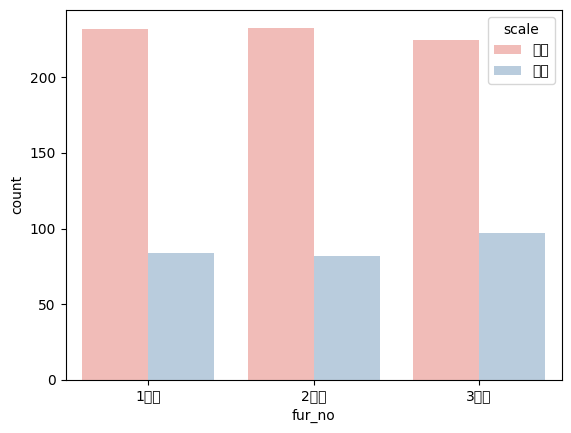

In [127]:
# 가열로 호기에 따라 불량 갯수 확인
sns.countplot(x='fur_no', hue = 'scale', data = df)


*   가열로 호기 차이에 따라 불량률이 크게 차이나지 않음

#### fur_input_row

<Axes: xlabel='fur_input_row', ylabel='count'>

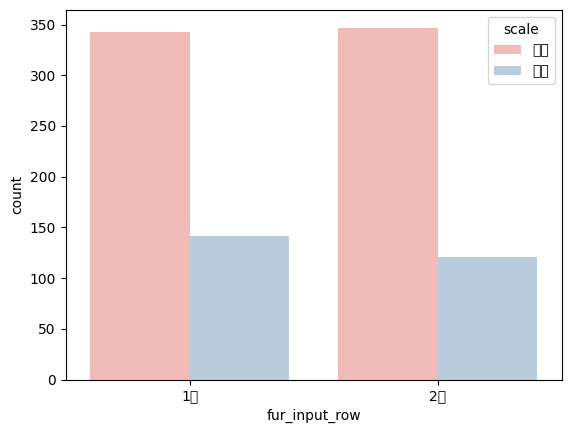

In [128]:
# 가열로 장입열에 따른 불량 갯수 확인
sns.countplot(x='fur_input_row', hue = 'scale', data = df)


*   가열로 장입열 차이에 따라 생기는 불량률은 크게 차이나지 않음

#### rolling_method

<Axes: xlabel='rolling_method', ylabel='count'>

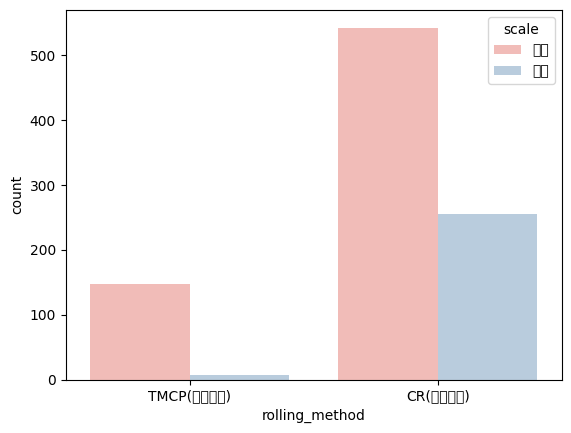

In [129]:
# 압연방법에 따른 불량 갯수 확인
sns.countplot(x='rolling_method', hue = 'scale', data = df)

*   제어압연으로 압연한 후판이 불량률이 훨씬 높음
*   제어압연(천천히 냉각), TMCP(급냉시키기)

#### work_group

<Axes: xlabel='work_group', ylabel='count'>

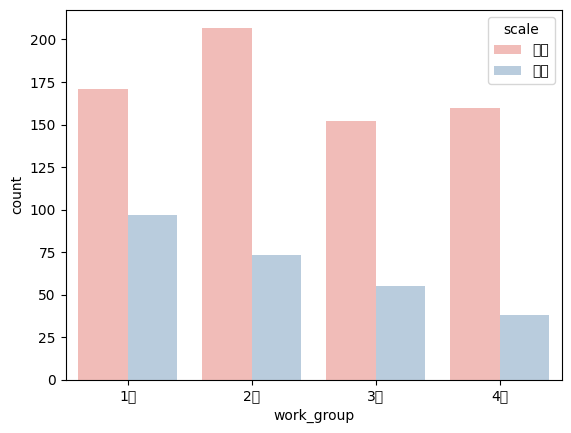

In [130]:
# 작업조에 따른 불량 갯수 확인
sns.countplot(x='work_group', hue = 'scale', data = df)

In [131]:
# 조별 불량률
df['scale'] = df['scale'].map(lambda x : 0 if x == "양품" else 1)
df_groups = df.groupby(["work_group"])["scale"]
print(df_groups)
df_w = pd.DataFrame(columns = ["work_group", "PROB"])
for name, g in df_groups:
    df_w = df_w.append({"work_group" : name , "PROB" : g.tolist().count(1)/(g.shape[0])}, ignore_index = True )
df_w

,work_group,PROB
0,1조,0.361940
1,2조,0.260714
2,3조,0.265700
3,4조,0.191919


*   조마다 불량률이 다름
    *   이유가 있는지? 4조 2교대 (7, 19시 기준 변경)
*   다른 변수들과의 관계(근무시간 등) 더 찾아보면 연관성을 찾을거라 예상
*   각 조마다 불량갯수를 비율로 나타내면 1, 3, 2, 4 순으로 불량률이 높음

##### work_group, day_yn 분할표

In [132]:
crosstab = pd.crosstab(df['day_yn'], df['work_group'], margins=True)
crosstab

work_group,1조,2조,3조,4조,All
day_yn,,,,,
야간,0,280,0,198,478
주간,268,0,207,0,475
All,268,280,207,198,953


*  1, 3조는 주간에 근무하고 2, 4조는 야간에 근무  
    -> 불량률이 높은 1, 3조가 같은 시간에 일하고 상대적으로 불량률이 낮은 2, 4조가 야간에 일했음을 확인  
    -> work_group 열을 제거하고 day_yn 열을 이용해 주간, 야간을 기준으로 불량 이유를 찾아본다.

In [133]:
# work_group 열 제거
df.drop(columns='work_group',inplace=True)

#### 변수 처리

In [134]:
# 단위가 같이 표현되어 있는 수치형 변수 처리  (fur_no, fur_input_row)
df['fur_no'] = df['fur_no'].str.replace('호기', '')
df['fur_input_row'] = df['fur_input_row'].str.replace('열', '')

#### 변수 검정

In [135]:
# 검정 결과를 저장할 딕셔너리 생성
chi2_results = {}

# 명목형 변수 간 카이제곱 검정을 위한 변수 리스트
variables = ['steel_kind', 'fur_no', 'fur_input_row', 'rolling_method', 'day_yn']

for var in variables:
    # 교차 테이블 생성
    cross_tab = pd.crosstab(df[var], df['scale'])
    # 카이제곱 검정 수행
    chi2, p, dof, expected = chi2_contingency(cross_tab)
    # 결과 저장
    chi2_results[var] = {'chi2': chi2, 'p-value': p, 'dof': dof}

# 검정 결과 출력
for var, result in chi2_results.items():

    print(f"{var}와 scale:")
    print(f"  카이제곱 통계량: {result['chi2']:.2f}")
    print(f"  p-value: {result['p-value']}")
    print(f"  자유도(dof): {result['dof']}\n")

steel_kind와 scale:
  카이제곱 통계량: 83.51
  p-value: 6.344605892246456e-20
  자유도(dof): 1

fur_no와 scale:
  카이제곱 통계량: 1.58
  p-value: 0.4542212948451264
  자유도(dof): 2

fur_input_row와 scale:
  카이제곱 통계량: 1.23
  p-value: 0.26719421459266435
  자유도(dof): 1

rolling_method와 scale:
  카이제곱 통계량: 47.48
  p-value: 5.551000932469287e-12
  자유도(dof): 1

day_yn와 scale:
  카이제곱 통계량: 8.75
  p-value: 0.0030892317474954275
  자유도(dof): 1



### 숫자형 변수

#### pt_thick

#### pt_width

#### pt_length

#### fur_heat_temp

<Axes: xlabel='scale', ylabel='fur_heat_temp'>

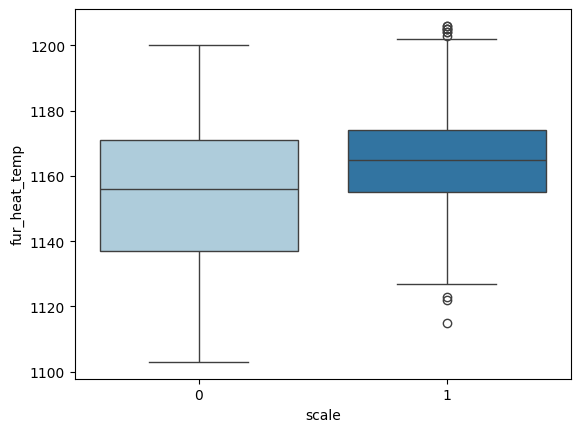

In [136]:
# 가열대 소재온도와 Scale 유무 관계
sns.boxplot(y = 'fur_heat_temp', x = 'scale' , data = df,palette=palette)

*   가열로 가열대 소재온도 (들어갔을 때를 기준이라고 판단)
*   가열대 소재온도랑 불량 유무의 관계를 결정하기엔 어렵다고 판단

<Axes: xlabel='fur_heat_temp', ylabel='Count'>

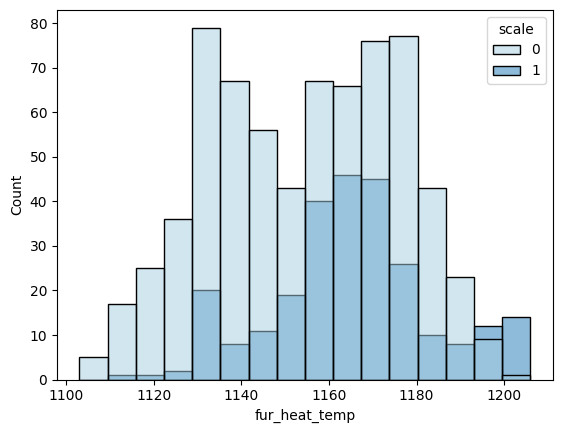

In [137]:
# 가열대 소재온도와 Scale 유무 확인
sns.histplot(x = 'fur_heat_temp', hue = 'scale' , data = df,palette=palette)



*   양품과 불량품의 흐름이 비슷하다고 판단해 가열대 소재온도와 Scale 유무의 관계를 결정하기엔 어렵다고 판단



#### fur_heat_time

<Axes: xlabel='scale', ylabel='fur_heat_time'>

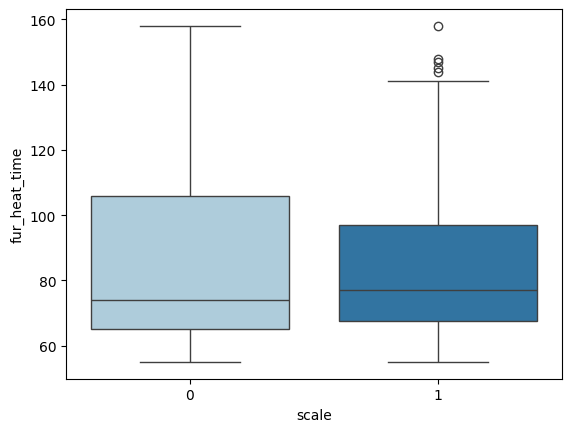

In [138]:
# 가열대 재로시간과 Scale 유무 관계
sns.boxplot(y = 'fur_heat_time', x = 'scale' , data = df ,palette=palette)

*   중앙값을 중심으로 값의 분포가 비대칭  
*   중앙값이 평균보다 작음

<Axes: xlabel='fur_heat_time', ylabel='Count'>

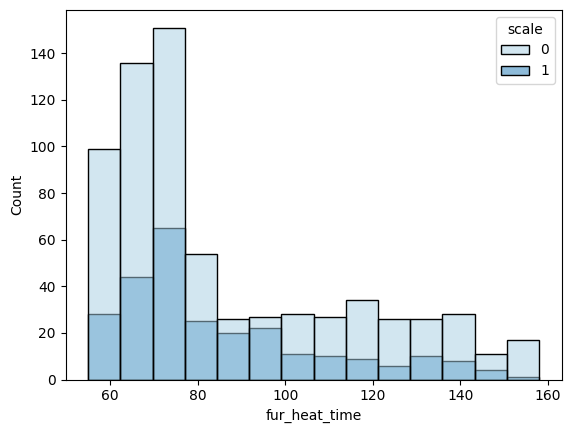

In [139]:
# 가열대 재로시간과 Scale 유무 확인
sns.histplot(x = 'fur_heat_time', hue = 'scale' , data = df,palette=palette)

#### fur_soak_temp

<Axes: xlabel='scale', ylabel='fur_soak_temp'>

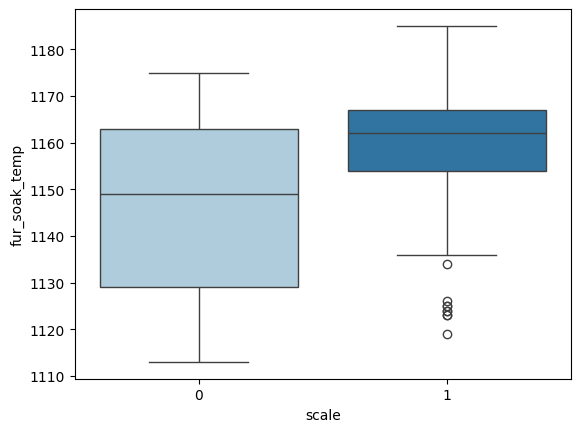

In [140]:
# 균열대 소재온도와 Sclae 유무 관계
sns.boxplot(y = 'fur_soak_temp', x = 'scale' , data = df ,palette=palette)

*   불량의 이상치가 많음
*   불량인 후판은 대부분 균열대로 갔을 때 온도가 높은 후판들이 Scale이 될 확률이 높음  
    -> 온도가 낮음에도 불량품이 되는 다른 이유가 있을 수 있다는 점을 알게됨

#### fur_soak_time

#### fur_total_time

<Axes: xlabel='scale', ylabel='fur_total_time'>

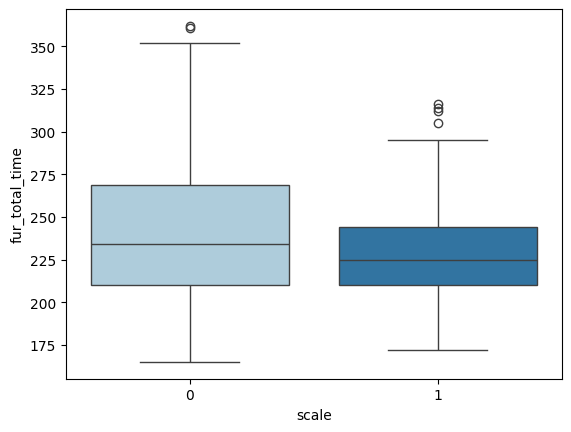

In [141]:
# 가열로 총 재로시간과 Scale 유무 관계
sns.boxplot(y = 'fur_total_time', x = 'scale' , data = df ,palette=palette)



*   가열로 총 재로시간에서 모든 불량품은 양품의 범위 안에 들어가있기에 총 재로시간과 Scale 유무의 관계를 결정하기엔 어렵다고 판단



#### fur_ex_temp

<Axes: xlabel='scale', ylabel='fur_ex_temp'>

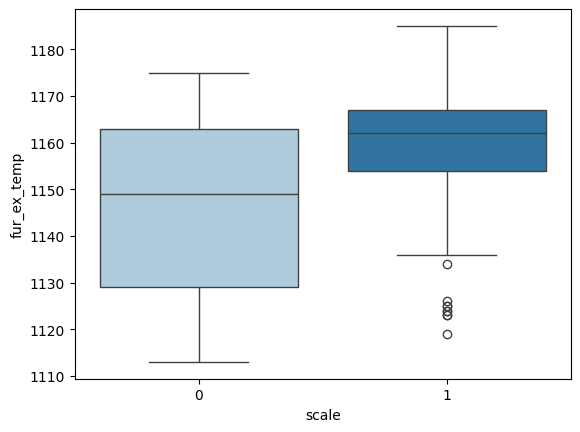

In [142]:
# 가열로 추출온도와 Scale 유무 관계
sns.boxplot(y = 'fur_ex_temp', x = 'scale' , data = df ,palette=palette)


*   불량 후판은 가열로 추출온도가 훨씬 높음
*   낮은 온도에서 Scale이 생긴 후판은 이상치로 잡힘  
    -> 대부분의 Scale은 높은 온도에서 생긴다는 가정을 만들 수 있음

<Axes: xlabel='fur_soak_temp', ylabel='fur_ex_temp'>

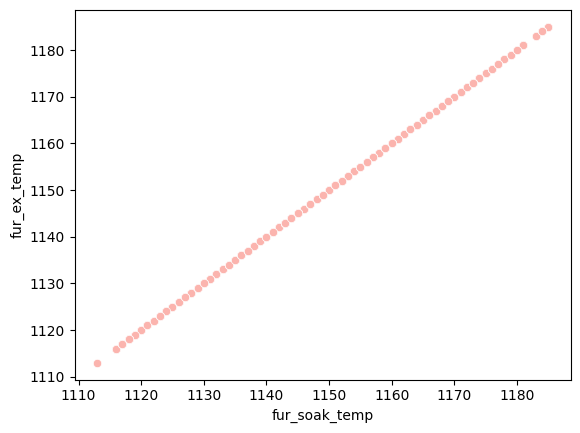

In [143]:
# 균열대 재로시간, 총 재로시간 그래프
sns.scatterplot(data=df, x="fur_soak_temp", y="fur_ex_temp")

*   균열대 재로시간과 총 재로시간은 y = x의 관계를 가지기 때문에 하나의 열로 관리  
    -> fur_ex_temp(가열로 추출온도)를 제거

In [144]:
df.drop("fur_ex_temp", axis = 1, inplace = True)
df.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn
0,0,AB/EH32-TM,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간
1,0,AB/EH32-TM,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간
2,0,NV-E36-TM,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간
3,0,NV-E36-TM,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간
4,0,BV-EH36-TM,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간


#### rolling_temp

<Axes: xlabel='scale', ylabel='rolling_temp'>

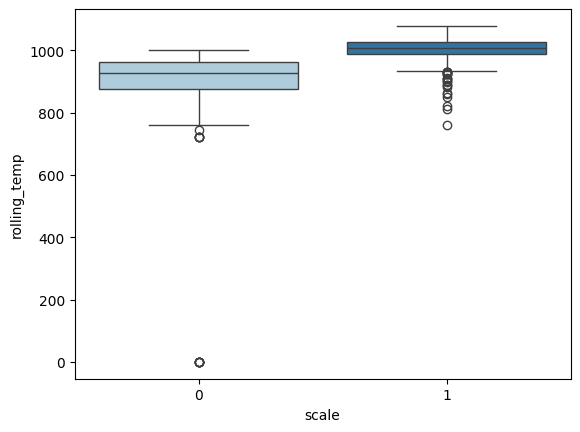

In [145]:
# 압연온도와 Scale 유무 관계
sns.boxplot(y = 'rolling_temp', x = 'scale' , data = df,palette=palette )

*   압연온도가 0도인 양품이 있음 (이상치 확인)

In [146]:
df[df['rolling_temp']==0]

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn
53,0,GL-E36-TM,독일,T,56,3800,11400,3,2,1132,95,1128,80,244,TMCP(온도제어),0,6,주간
221,0,JS-SM490YB,일본,C,16,2200,43600,3,2,1163,57,1166,67,228,CR(제어압연),0,10,야간
222,0,JS-SM490YB,일본,C,16,2200,43600,3,1,1169,64,1164,61,188,CR(제어압연),0,10,야간
598,0,PILAC-BT33,한국,T,81,2100,12900,2,1,1133,89,1122,59,229,CR(제어압연),0,6,주간
599,0,PILAC-BT33,한국,T,81,2100,13200,1,2,1130,92,1124,61,210,CR(제어압연),0,6,주간
600,0,NV-D32-TM,영국,T,40,2500,23600,3,1,1119,109,1117,76,260,TMCP(온도제어),0,6,주간


*  rolling_temp에 0인 6개의 행 존재  
*  이 값을 대체할 근거가 마땅하지 않음  
    -> 제거

In [147]:
# 0인 행 제거
df = df[df['rolling_temp'] != 0]

<Axes: xlabel='scale', ylabel='rolling_temp'>

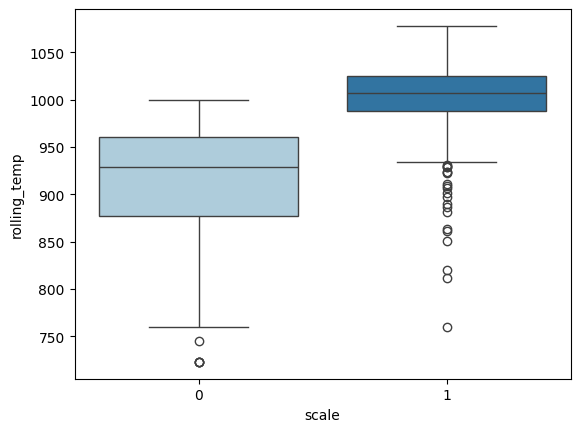

In [148]:
# 삭제 후 boxplot 확인
sns.boxplot(y = 'rolling_temp', x = 'scale' , data = df,palette=palette )



*   양품의 온도보다 높은 온도에서 압연을 할 시, 불량품이 될 확률 증가



#### descaling_count

#### 변수 검정

In [149]:
# 연속형 변수 검정 진행
variables = [
    "pt_thick", "pt_width", "pt_length",
    "fur_heat_temp", "fur_heat_time", "fur_soak_time",
    "fur_total_time", "rolling_temp"
]

# 결과를 저장할 딕셔너리 초기화
final_results = {}

for var in variables:
    # '양품'과 '불량' 데이터 분리
    data_good = df[df['scale'] == 0][var]
    data_bad = df[df['scale'] == 1][var]

    # 정규성 검정 (Shapiro-Wilk test)
    normality_good = shapiro(data_good)
    normality_bad = shapiro(data_bad)

    # 등분산성 검정 (Levene's test)
    equal_var_test = levene(data_good, data_bad)

    # Two-sample t-test (등분산 가정하지 않음)
    ttest_result = ttest_ind(data_good, data_bad, equal_var=False)

    # 결과 저장
    final_results[var] = {
        'normality_p_good': normality_good.pvalue,
        'normality_p_bad': normality_bad.pvalue,
        'levene_p': equal_var_test.pvalue,
        'ttest_p': ttest_result.pvalue
    }

# 결과 출력
for var, results in final_results.items():
    print(f"{var}:")
    print(f"  Shapiro-Wilk Test - Good: p={results['normality_p_good']:.2e}, Bad: p={results['normality_p_bad']:.2e}")
    print(f"  Levene's Test: p={results['levene_p']:.2e}")
    print(f"  T-Test: p={results['ttest_p']:.2e}\n")

pt_thick:
  Shapiro-Wilk Test - Good: p=2.57e-30, Bad: p=1.12e-22
  Levene's Test: p=2.69e-10
  T-Test: p=1.02e-04

pt_width:
  Shapiro-Wilk Test - Good: p=7.94e-08, Bad: p=3.14e-13
  Levene's Test: p=1.52e-01
  T-Test: p=1.54e-11

pt_length:
  Shapiro-Wilk Test - Good: p=3.44e-22, Bad: p=7.51e-07
  Levene's Test: p=7.66e-22
  T-Test: p=1.17e-01

fur_heat_temp:
  Shapiro-Wilk Test - Good: p=6.05e-09, Bad: p=4.31e-04
  Levene's Test: p=3.98e-06
  T-Test: p=9.71e-14

fur_heat_time:
  Shapiro-Wilk Test - Good: p=1.28e-24, Bad: p=3.25e-13
  Levene's Test: p=2.76e-02
  T-Test: p=3.63e-01

fur_soak_time:
  Shapiro-Wilk Test - Good: p=5.92e-19, Bad: p=2.90e-09
  Levene's Test: p=8.13e-10
  T-Test: p=1.25e-19

fur_total_time:
  Shapiro-Wilk Test - Good: p=1.61e-12, Bad: p=1.07e-06
  Levene's Test: p=5.65e-12
  T-Test: p=3.87e-07

rolling_temp:
  Shapiro-Wilk Test - Good: p=3.52e-14, Bad: p=1.40e-15
  Levene's Test: p=7.33e-12
  T-Test: p=2.72e-84



# 철강 규격별 용도 분류

In [150]:
# 용도에 따른 철강 규격 데이터
steel_spec = [
    "A131-DH36TM 선체구조용(조선용)",
    "BV-AH36-TL 선체구조용(조선용)",
    "SA283-C 용접구조용",
    "A283-C 보일러및압력용기용",
    "JS-SM400A 용접구조용",
    "NK-KD36-TM 선체구조용(조선용)",
    "GL-D36-TM 선체구조용(조선용)",
    "PILAC-BT33 구조용압연강재",
    "NV-A36-TM 선체구조용(조선용)",
    "BV-AH36-TM 선체구조용(조선용)",
    "KS-HSB500 교량구조용",
    "API-2W-50T 해양구조용",
    "GL-A36-TM 선체구조용(조선용)",
    "NV-A32-TM 선체구조용(조선용)",
    "NV-D32-TM 선체구조용(조선용)",
    "NK-KA32-TM 선체구조용(조선용)",
    "GL-A32-TM 선체구조용(조선용)",
    "LR-AH36-TM 선체구조용(조선용)",
    "LR-EH32-TM 선체구조용(조선용)",
    "NV-E32-TM 선체구조용(조선용)",
    "AB/EH32-TM 선체구조용(조선용)",
    "NV-E36-TM 선체구조용(조선용)",
    "BV-EH36-TM 선체구조용(조선용)",
    "AB/EH36-TM 선체구조용(조선용)",
    "BV-AH32-TM 선체구조용(조선용)",
    "GL-E32-TM 선체구조용(조선용)",
    "GL-E36-TM 선체구조용(조선용)",
    "BV-EH32-TM 선체구조용(조선용)",
    "KS-HSB600 교량구조용",
    "LR-EH36-TM 선체구조용(조선용)",
    "BV-B 선체구조용(조선용)",
    "AB/B 선체구조용(조선용)",
    "LR-B 선체구조용(조선용)",
    "JS-SM490YB 용접구조용",
    "KR-B 선체구조용(조선용)",
    "LR-A 선체구조용(조선용)",
    "JS-SM490A 용접구조용",
    "KS-SM400B 용접구조용",
    "JS-SM400B 용접구조용",
    "KS-SS400 일반구조용",
    "KR-A 선체구조용(조선용)",
    "JS-SS400 일반구조용",
    "NV-A 선체구조용(조선용)",
    "KS-SM400A 용접구조용",
    "KS-SM490B 용접구조용",
    "V42JBN3 선체구조용(조선용)",
    "AB/A 선체구조용(조선용)",
    "A516-60 보일러및압력용기용",
    "BV-AH32 선체구조용(조선용)",
    "JS-SM490YA 용접구조용",
    "AB/AH32 선체구조용(조선용)",
    "GL-A32 선체구조용(조선용)",
    "LR-AH32 선체구조용(조선용)",
    "CCS-B 선체구조용(조선용)",
    "NV-B 선체구조용(조선용)",
    "NV-A32 선체구조용(조선용)",
    "KS-SM490A 용접구조용",
    "GL-A 선체구조용(조선용)",
    "NK-KA32 선체구조용(조선용)",
    "LR-AH36 선체구조용(조선용)",
    "A709-36 교량구조용",
    "KR-AH32 선체구조용(조선용)",
    "BV-A 선체구조용(조선용)",
    "NK-KA 선체구조용(조선용)",
    "NV-D36-TM 선체구조용(조선용)"
]

In [151]:
# 규격과 용도에 맞게 분리 후 Dictionary로 저장
steel_spec_dict_updated = {spec.split(" ")[0]: " ".join(spec.split(" ")[1:]) for spec in steel_spec}

In [152]:
# spec_long 열에서 COMMON(공통)인 행은 purpose에 COMMON으로 추가
purpose_list = []
for i in df['spec_long']:
    tmp = steel_spec_dict_updated.get(i, "COMMON")
    purpose_list.append(tmp)

df['purpose'] = purpose_list
df[['spec_long','purpose']].head(20)

,spec_long,purpose
0,AB/EH32-TM,선체구조용(조선용)
1,AB/EH32-TM,선체구조용(조선용)
2,NV-E36-TM,선체구조용(조선용)
3,NV-E36-TM,선체구조용(조선용)
4,BV-EH36-TM,선체구조용(조선용)
5,BV-EH36-TM,선체구조용(조선용)
6,BV-EH36-TM,선체구조용(조선용)
7,BV-EH36-TM,선체구조용(조선용)
8,BV-EH36-TM,선체구조용(조선용)
9,AB/EH36-TM,선체구조용(조선용)


In [153]:
# 규격별 양품과 불량 비율
pd.DataFrame(df.groupby("purpose")['scale'].value_counts(normalize=True))

scale
purpose    scale          
COMMON     0      0.916667
           1      0.083333
교량구조용      0      1.000000
구조용압연강재    0      1.000000
보일러및압력용기용  1      0.750000
           0      0.250000
선체구조용(조선용) 0      0.792481
           1      0.207519
용접구조용      1      0.544910
           0      0.455090
일반구조용      1      0.862069
           0      0.137931
해양구조용      0      1.000000

In [154]:
# 불량률이 높은 규격
specified_purposes = ['선체구조용(조선용)', '용접구조용', '일반구조용']

# 불량률이 낮은 규격들은 OTHERS로 변경 (구조용압연강재, 보일러및압력용기용, 교량구조용, 해양구조용, COMMON)
df['purpose'] = df['purpose'].apply(lambda x: x if x in specified_purposes else 'OTHERS')

# Display the first few rows to verify the changes
df['purpose'].head()

0    선체구조용(조선용)
1    선체구조용(조선용)
2    선체구조용(조선용)
3    선체구조용(조선용)
4    선체구조용(조선용)
Name: purpose, dtype: object

In [155]:
df.purpose.unique()

array(['선체구조용(조선용)', 'OTHERS', '용접구조용', '일반구조용'], dtype=object)

In [156]:
# 불필요한 칼럼 삭제
df.drop(columns='spec_long',inplace=True)

In [157]:
df.columns

Index(['scale', 'spec_country', 'steel_kind', 'pt_thick', 'pt_width',
       'pt_length', 'fur_no', 'fur_input_row', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'day_yn',
       'purpose'],
      dtype='object')

### 결측치 확인

In [158]:
df.isnull().sum()

scale              0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_method     0
rolling_temp       0
descaling_count    0
day_yn             0
purpose            0
dtype: int64



*   NaN값 존재하지 않음



### 설명변수간 관계

<Axes: >

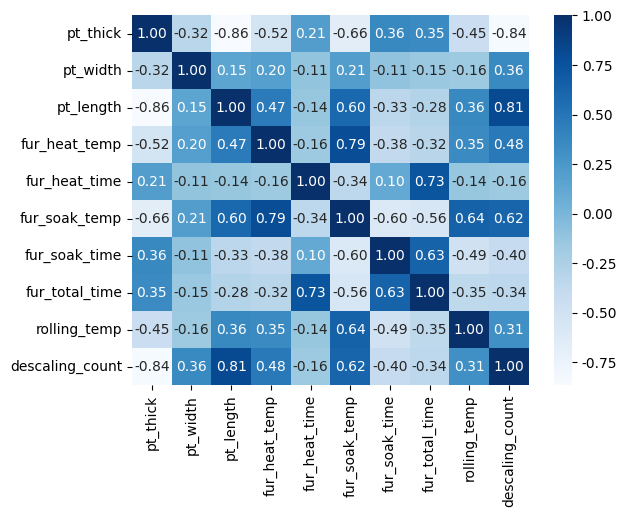

In [159]:
df_corr= df.drop(columns='scale').corr().round(3)
sns.heatmap(df_corr, annot = True, fmt = ".2f", cmap= "Blues")

- pt_length와 descaling_count의 상관계수: 0.81(양의 선형관계)
- pt_thick와 pt_length의 상관계수: -0.86(음의 선형관계)
- pt_thick와 descaling_count의 상관계수: -0.84(음의 선형관계)
- fur_heat_temp와 fur_soak_temp의 상관계수: 0.79(양의 선형관계)

In [160]:
df

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,프랑스,C,19,3400,41500,1,2,1142,55,1151,86,203,CR(제어압연),948,10,야간,선체구조용(조선용)
996,0,영국,C,19,3400,41500,1,2,1142,55,1151,86,209,CR(제어압연),948,10,야간,선체구조용(조선용)
997,0,미국,C,17,3400,43700,2,2,1169,65,1163,77,227,CR(제어압연),948,10,야간,선체구조용(조선용)
998,0,영국,C,17,3400,43700,2,2,1169,65,1163,77,204,CR(제어압연),948,10,야간,선체구조용(조선용)


<Axes: xlabel='fur_heat_temp', ylabel='fur_soak_temp'>

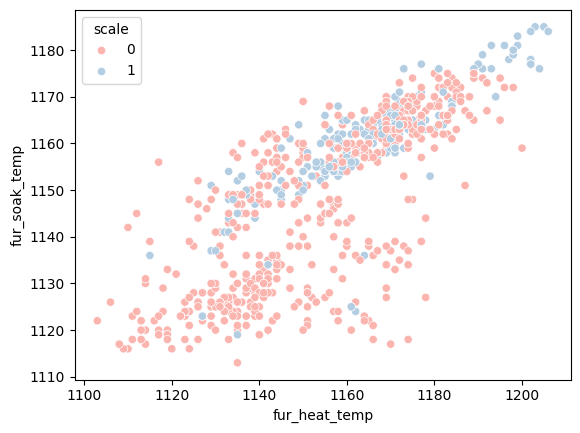

In [161]:
sns.scatterplot(data=df, x="fur_heat_temp", y="fur_soak_temp", hue="scale")

*   scale을 기준으로 서로 다른 양의 선형관계를 보이고있음
*   세부적으로 볼 필요 있음


<Axes: xlabel='descaling_count', ylabel='count'>

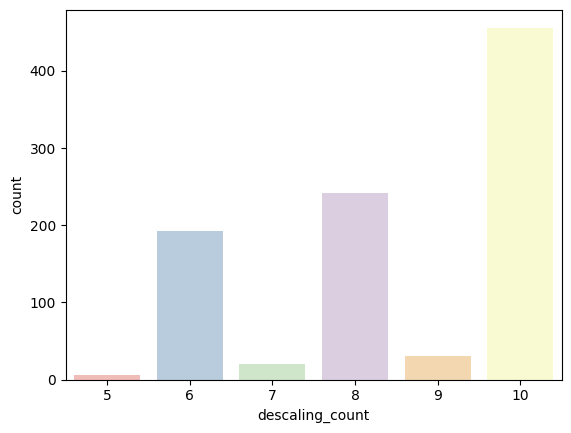

In [162]:
sns.countplot(data=df,x="descaling_count", palette=colors)

*   짝수로 할 경우 불량률이 높음

In [163]:
df

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
0,0,미국,T,32,3700,15100,1,1,1144,116,1133,59,259,TMCP(온도제어),934,8,주간,선체구조용(조선용)
1,0,미국,T,32,3700,15100,1,2,1144,122,1135,53,238,TMCP(온도제어),937,8,주간,선체구조용(조선용)
2,0,영국,T,33,3600,19200,2,1,1129,116,1121,55,258,TMCP(온도제어),889,8,주간,선체구조용(조선용)
3,0,영국,T,33,3600,19200,2,2,1152,125,1127,68,266,TMCP(온도제어),885,8,주간,선체구조용(조선용)
4,0,프랑스,T,38,3100,13300,3,1,1140,134,1128,48,246,TMCP(온도제어),873,8,주간,선체구조용(조선용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,프랑스,C,19,3400,41500,1,2,1142,55,1151,86,203,CR(제어압연),948,10,야간,선체구조용(조선용)
996,0,영국,C,19,3400,41500,1,2,1142,55,1151,86,209,CR(제어압연),948,10,야간,선체구조용(조선용)
997,0,미국,C,17,3400,43700,2,2,1169,65,1163,77,227,CR(제어압연),948,10,야간,선체구조용(조선용)
998,0,영국,C,17,3400,43700,2,2,1169,65,1163,77,204,CR(제어압연),948,10,야간,선체구조용(조선용)


# 데이터 저장

In [164]:
# df.to_csv('real_real_final_scale.csv',index=False)

In [ ]:
# zz=pd.read_csv('/content/final_scale.csv',encoding='utf-8')
# zz

# 데이터 분할

In [ ]:
# # df 이름 변경
# df_raw = pd.read_csv("/content/drive/MyDrive/BigData/real_final_scale.csv")

In [165]:
df_raw=df.copy()

In [166]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            947 non-null    int64 
 1   spec_country     947 non-null    object
 2   steel_kind       947 non-null    object
 3   pt_thick         947 non-null    int64 
 4   pt_width         947 non-null    int64 
 5   pt_length        947 non-null    int64 
 6   fur_no           947 non-null    object
 7   fur_input_row    947 non-null    object
 8   fur_heat_temp    947 non-null    int64 
 9   fur_heat_time    947 non-null    int64 
 10  fur_soak_temp    947 non-null    int64 
 11  fur_soak_time    947 non-null    int64 
 12  fur_total_time   947 non-null    int64 
 13  rolling_method   947 non-null    object
 14  rolling_temp     947 non-null    int64 
 15  descaling_count  947 non-null    int64 
 16  day_yn           947 non-null    object
 17  purpose          947 non-null    ob

#### 문자열 변환

In [70]:
# df_raw['fur_no'] = df_raw['fur_no'].astype(str)
# df_raw['fur_input_row'] = df_raw['fur_input_row'].astype(str)
# # df_raw['descaling_count'] = df_raw['descaling_count'].apply(lambda x: 'odd' if x % 2 != 0 else str(x))  # 홀수는 'odd', 짝수는 문자열로 범주화

In [171]:
df_raw_x = df_raw.drop('scale', axis=1)
df_raw_x_1 = df_raw.drop(["scale",'steel_kind', 'day_yn', 'rolling_method'], axis=1)
df_raw_x_2 = df_raw[['steel_kind', 'day_yn', 'rolling_method']]  # 범주가 2개인 자료는 따로 dummy화
df_raw_y = df_raw['scale']

Index(['spec_country', 'steel_kind', 'pt_thick', 'pt_width', 'pt_length',
       'fur_no', 'fur_input_row', 'fur_heat_temp', 'fur_heat_time',
       'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'rolling_method',
       'rolling_temp', 'descaling_count', 'day_yn', 'purpose'],
      dtype='object')
Index(['spec_country', 'pt_thick', 'pt_width', 'pt_length', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'rolling_temp', 'descaling_count',
       'purpose'],
      dtype='object')
Index(['steel_kind', 'day_yn', 'rolling_method'], dtype='object')


In [175]:
# 범주형 변수 선택 : select_dtypes="object"
df_raw_x_char_1 = df_raw_x_1.select_dtypes(include = "object")
df_raw_x_char_2 = df_raw_x_2.select_dtypes(include = "object")
df_raw_x_char = pd.concat([df_raw_x_char_1, df_raw_x_char_2], axis=1).reset_index(drop=True)

# get_dummies: 범주형 변수에 대한 더미변환
df_x_dummy_1 = pd.get_dummies(df_raw_x_char_1)
df_x_dummy_2 = pd.get_dummies(df_raw_x_char_2, drop_first=True) # 범주가 2개인 자료는 따로 dummy화
df_x_dummy = pd.concat([df_x_dummy_1, df_x_dummy_2], axis=1).reset_index(drop=True)


# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object").reset_index(drop=True)

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

# 원래 연속형(df_raw_x_num) + 원래 범주형(df_x_dummy)
df_x_raw_raw = df_raw_x_num.join(df_raw_x_char)
display("원래 연속형+ 원래 범주형...회귀 용:",df_x_raw_raw.head(3))

# 원래 연속형(df_raw_x_num) + dummy된 범주형(df_x_dummy)
df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:",df_x_raw_dummy.head(3))

# scale된 연속형(df_x_scaled)+ dummy된 범주형(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:",df_x_scale_dummy.head(3))

# scale된 연속형(df_x_scaled) + 원래 범주형(df_raw_x_char)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)
display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_x_scale_raw.head(3))

'원래 연속형+ 원래 범주형...회귀 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
0,32,3700,15100,1144,116,1133,59,259,934,8,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어)
1,32,3700,15100,1144,122,1135,53,238,937,8,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어)
2,33,3600,19200,1129,116,1121,55,258,889,8,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어)


pt_thick           0
pt_width           0
pt_length          0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_temp       0
descaling_count    0
spec_country       0
fur_no             0
fur_input_row      0
purpose            0
steel_kind         0
day_yn             0
rolling_method     0
dtype: int64


'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,32,3700,15100,1144,116,1133,59,259,934,8,...,0,1,0,0,1,0,0,1,1,1
1,32,3700,15100,1144,122,1135,53,238,937,8,...,0,0,1,0,1,0,0,1,1,1
2,33,3600,19200,1129,116,1121,55,258,889,8,...,0,1,0,0,1,0,0,1,1,1


pt_thick                     0
pt_width                     0
pt_length                    0
fur_heat_temp                0
fur_heat_time                0
fur_soak_temp                0
fur_soak_time                0
fur_total_time               0
rolling_temp                 0
descaling_count              0
spec_country_공통              0
spec_country_독일              0
spec_country_미국              0
spec_country_영국              0
spec_country_일본              0
spec_country_프랑스             0
spec_country_한국              0
fur_no_1                     0
fur_no_2                     0
fur_no_3                     0
fur_input_row_1              0
fur_input_row_2              0
purpose_OTHERS               0
purpose_선체구조용(조선용)           0
purpose_용접구조용                0
purpose_일반구조용                0
steel_kind_T                 0
day_yn_주간                    0
rolling_method_TMCP(온도제어)    0
dtype: int64


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,...,0,1,0,0,1,0,0,1,1,1
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,...,0,0,1,0,1,0,0,1,1,1
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,...,0,1,0,0,1,0,0,1,1,1


pt_thick                     0
pt_width                     0
pt_length                    0
fur_heat_temp                0
fur_heat_time                0
fur_soak_temp                0
fur_soak_time                0
fur_total_time               0
rolling_temp                 0
descaling_count              0
spec_country_공통              0
spec_country_독일              0
spec_country_미국              0
spec_country_영국              0
spec_country_일본              0
spec_country_프랑스             0
spec_country_한국              0
fur_no_1                     0
fur_no_2                     0
fur_no_3                     0
fur_input_row_1              0
fur_input_row_2              0
purpose_OTHERS               0
purpose_선체구조용(조선용)           0
purpose_용접구조용                0
purpose_일반구조용                0
steel_kind_T                 0
day_yn_주간                    0
rolling_method_TMCP(온도제어)    0
dtype: int64


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
0,0.298839,1.765880,-1.561273,-0.623951,1.13104,-1.034421,-0.615879,0.534990,-0.103218,-0.342411,미국,1,1,선체구조용(조선용),T,주간,TMCP(온도제어)
1,0.298839,1.765880,-1.561273,-0.623951,1.35857,-0.918753,-0.906940,-0.017416,-0.056516,-0.342411,미국,1,2,선체구조용(조선용),T,주간,TMCP(온도제어)
2,0.354957,1.562785,-1.265674,-1.333010,1.13104,-1.728433,-0.809920,0.508684,-0.803747,-0.342411,영국,2,1,선체구조용(조선용),T,주간,TMCP(온도제어)


pt_thick           0
pt_width           0
pt_length          0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
rolling_temp       0
descaling_count    0
spec_country       0
fur_no             0
fur_input_row      0
purpose            0
steel_kind         0
day_yn             0
rolling_method     0
dtype: int64


In [176]:
## train_test_split
# 원래 연속형+ 원래 범주형...회귀분석 용:df_x_raw_dummy
df_train_x_lo, df_test_x_lo, df_train_y, df_test_y = train_test_split(df_x_raw_raw,df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_raw["steel_kind"], random_state = 2024)
display("원래 연속형+ 원래 범주형...DT/RF/GB 용:", df_train_x_lo.head())

# 원래 연속형+ Dummied 범주형...DT/RF/GB 용:df_x_raw_dummy
df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_raw_dummy["steel_kind_T"], random_state=2024)

display("원래 연속형+ Dummied 범주형...DT/RF/GB 용:", df_train_x_rd.head())

# 기계학습용 데이터(Scaled 연속형+ Dummied 범주형) 분할:df_x_scale_dummy
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.3, stratify = df_x_scale_dummy["steel_kind_T"], random_state=2024)

display("Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:", df_train_x_sd.head())

# 회귀분석용(표준화 회귀계수) 데이터(Scaled 연속형+ 원래 범주형) 분할:df_x_scale_raw
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.3, stratify = df_x_scale_raw["steel_kind"], random_state=2024)

display("Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):",df_train_x_reg.head())

'원래 연속형+ 원래 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
565,81,2900,9800,1139,132,1124,80,287,877,6,한국,2,2,OTHERS,T,주간,CR(제어압연)
771,26,2600,31300,1165,73,1160,63,223,1026,8,미국,2,1,OTHERS,C,야간,CR(제어압연)
46,51,3100,12400,1133,57,1125,103,238,862,6,미국,3,1,선체구조용(조선용),T,주간,TMCP(온도제어)
703,19,2700,54300,1178,69,1165,57,227,1005,10,영국,3,1,선체구조용(조선용),C,주간,CR(제어압연)
457,14,2900,54300,1166,72,1163,60,221,923,10,한국,3,1,용접구조용,C,주간,CR(제어압연)


'원래 연속형+ Dummied 범주형...DT/RF/GB 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,81,2900,9800,1139,132,1124,80,287,877,6,...,0,0,1,1,0,0,0,1,1,0
771,26,2600,31300,1165,73,1160,63,223,1026,8,...,0,1,0,1,0,0,0,0,0,0
46,51,3100,12400,1133,57,1125,103,238,862,6,...,1,1,0,0,1,0,0,1,1,1
703,19,2700,54300,1178,69,1165,57,227,1005,10,...,1,1,0,0,1,0,0,0,1,0
457,14,2900,54300,1166,72,1163,60,221,923,10,...,1,1,0,0,0,1,0,0,1,0


'Scaled 연속형+ Dummied 범주형...SVM/NN/KNN 용:'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,...,fur_no_3,fur_input_row_1,fur_input_row_2,purpose_OTHERS,purpose_선체구조용(조선용),purpose_용접구조용,purpose_일반구조용,steel_kind_T,day_yn_주간,rolling_method_TMCP(온도제어)
565,3.048596,0.141116,-1.943388,-0.860304,1.737786,-1.554930,0.402834,1.271531,-0.990555,-1.594390,...,0,0,1,1,0,0,0,1,1,0
771,-0.037866,-0.468171,-0.393299,0.368730,-0.499588,0.527104,-0.421839,-0.411992,1.328976,-0.342411,...,0,1,0,1,0,0,0,0,0,0
46,1.365071,0.547307,-1.755935,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,-1.224065,-1.594390,...,1,1,0,0,1,0,0,1,1,1
703,-0.430688,-0.265075,1.264936,0.983248,-0.651274,0.816276,-0.712900,-0.306772,1.002062,0.909569,...,1,1,0,0,1,0,0,0,1,0
457,-0.711276,0.141116,1.264936,0.416001,-0.537509,0.700607,-0.567369,-0.464602,-0.274458,0.909569,...,1,1,0,0,0,1,0,0,1,0


'Scaled 연속형+ 원래 범주형...회귀분석용(표준화 회귀계수):'

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method
565,3.048596,0.141116,-1.943388,-0.860304,1.737786,-1.554930,0.402834,1.271531,-0.990555,-1.594390,한국,2,2,OTHERS,T,주간,CR(제어압연)
771,-0.037866,-0.468171,-0.393299,0.368730,-0.499588,0.527104,-0.421839,-0.411992,1.328976,-0.342411,미국,2,1,OTHERS,C,야간,CR(제어압연)
46,1.365071,0.547307,-1.755935,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,-1.224065,-1.594390,미국,3,1,선체구조용(조선용),T,주간,TMCP(온도제어)
703,-0.430688,-0.265075,1.264936,0.983248,-0.651274,0.816276,-0.712900,-0.306772,1.002062,0.909569,영국,3,1,선체구조용(조선용),C,주간,CR(제어압연)
457,-0.711276,0.141116,1.264936,0.416001,-0.537509,0.700607,-0.567369,-0.464602,-0.274458,0.909569,한국,3,1,용접구조용,C,주간,CR(제어압연)


# 모델링

## LogisticRegression

In [177]:
## train_test_split for Logistic Regression
df_train_x_lo, df_test_x_lo, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                                      test_size = 0.3,random_state = 2024,
                                                                      stratify = df_x_raw_dummy["steel_kind_T"])
# train 데이터 병합
df_logit = pd.concat([df_train_x_lo,df_train_y],axis=1)
df_logit

,spec_country,steel_kind,pt_thick,pt_width,pt_length,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose,scale
593,한국,T,81,2900,9800,2,2,1139,132,1124,80,287,CR(제어압연),877,6,주간,OTHERS,0
817,미국,C,26,2600,31300,2,1,1165,73,1160,63,223,CR(제어압연),1026,8,야간,OTHERS,1
46,미국,T,51,3100,12400,3,1,1133,57,1125,103,238,TMCP(온도제어),862,6,주간,선체구조용(조선용),0
744,영국,C,19,2700,54300,3,1,1178,69,1165,57,227,CR(제어압연),1005,10,주간,선체구조용(조선용),1
478,한국,C,14,2900,54300,3,1,1166,72,1163,60,221,CR(제어압연),923,10,주간,용접구조용,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,영국,C,14,2800,54400,3,2,1168,72,1161,60,187,CR(제어압연),941,10,야간,선체구조용(조선용),0
485,영국,C,18,3100,46300,3,1,1194,73,1170,61,213,CR(제어압연),982,9,주간,선체구조용(조선용),1
934,영국,C,20,2900,49400,3,2,1177,72,1166,60,237,CR(제어압연),998,10,주간,선체구조용(조선용),0
18,공통,T,34,2200,30500,2,1,1119,126,1119,72,263,CR(제어압연),931,8,주간,OTHERS,0


### 로지스틱 회귀모델 및 회귀계수 검토

In [178]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + descaling_count +
       fur_total_time + rolling_temp + C(spec_country) + C(steel_kind) + C(rolling_method) + C(purpose)+C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.281404
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      636
Method:                           MLE   Df Model:                           25
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5191
Time:                        04:51:36   Log-Likelihood:                -186.29
converged:                      False   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.127e-69
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -113.0159    850.937     -0.133      0.894   -1780.822    1554.790
C(

#### P-value 기준 유의하지 않은 변수 내림차순 제거

In [ ]:
#C(spec_country) 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + descaling_count +
       fur_total_time + rolling_temp + C(steel_kind) + C(rolling_method) + C(purpose)+C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.286299
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      642
Method:                           MLE   Df Model:                           19
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5107
Time:                        02:29:36   Log-Likelihood:                -189.53
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.486e-72
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -128.1864     25.113     -5.104  

In [ ]:
#fur_soak_time  제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(steel_kind) + C(rolling_method) + C(purpose)+C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.286427
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      643
Method:                           MLE   Df Model:                           18
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5105
Time:                        02:29:37   Log-Likelihood:                -189.61
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 7.938e-73
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -129.5611     24.875     -5.208  

In [ ]:
#C(purpose) 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(steel_kind) + C(rolling_method) +C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.289508
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      646
Method:                           MLE   Df Model:                           15
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5052
Time:                        02:29:37   Log-Likelihood:                -191.65
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 4.385e-74
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -126.4276     24.367     -5.188  

In [ ]:
#C(fur_no) 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(steel_kind) + C(rolling_method) +C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.291570
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5017
Time:                        02:29:37   Log-Likelihood:                -193.02
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 5.460e-75
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -126.5372     24.167     -5.236  

In [ ]:
#C(steel_kind) 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) +C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.292020
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                           12
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5009
Time:                        02:29:38   Log-Likelihood:                -193.32
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.253e-75
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -136.7506     20.613     -6.634  

In [ ]:
#C(fur_input_row)제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_thick + pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) +C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.292823
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      650
Method:                           MLE   Df Model:                           11
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4996
Time:                        02:29:40   Log-Likelihood:                -193.85
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.458e-76
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -136.0166     20.580     -6.609  

In [ ]:
#pt_thick 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) +C(day_yn) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.293538
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4983
Time:                        02:29:40   Log-Likelihood:                -194.32
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 8.594e-77
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -142.3017     19.682     -7.230  

In [ ]:
#C(day_yn) 제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.295175
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      652
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4956
Time:                        02:29:40   Log-Likelihood:                -195.41
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.689e-77
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -140.3729     19.425     -7.226  

In [ ]:
#C(rolling_method)제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.296678
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      653
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4930
Time:                        02:29:40   Log-Likelihood:                -196.40
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.372e-77
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -132.3110     18.167     -7.283      0.000    -167.917     -96.705
pt_width      

In [ ]:
#fur_total_time제거
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula(""" scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
        rolling_temp """, df_logit)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.298257
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      654
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4903
Time:                        02:29:43   Log-Likelihood:                -197.45
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 5.014e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -137.4071     17.807     -7.717      0.000    -172.308    -102.506
pt_width      

### 최종 모델

In [ ]:
#fur_heat_temp 제거한 최종 모델
# from_formula 함수를 이용하여 변수 역할 지정
log_final = Logit.from_formula(""" scale ~ pt_width + pt_length +
         fur_heat_time + fur_soak_temp + descaling_count +
        rolling_temp """, df_logit)
# 적합
log_result = log_final.fit()

# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.300340
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      655
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4867
Time:                        02:29:46   Log-Likelihood:                -198.82
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 2.359e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -143.2162     17.316     -8.271      0.000    -177.155    -109.277
pt_width      

##### 회귀계수 유의성 기준 제외 변수:
-  pt_thick, C(fur_no), C(fur_input_row),
       fur_heat_temp,fur_soak_time,
       fur_total_time, C(spec_country),C(steel_kind),C(rolling_method), C(purpose),C(day_yn)
### 유의한 변수
- pt_width, pt_length, fur_heat_time, fur_soak_temp,  descaling_count, rolling_temp

##### 최종 모델 요약
- No.Observations (전체 자료 수): 662

- Df Residuals (잔차 자유도) : 655

- Df Model (모델 자유도):6

- 설명력(R2): 0.4867
- 로지스틱 회귀분석의 설명력은 낮다

### 최종 회귀식
- y\h = - 143.2162 + -0.0011(pt.width)- 0.000042(pt_length)+ 0.0142(fur_heat_time)+ 0.1058(fur_soak_temp)-0.6455(descaling_count)+0.0301(rolling_temp)

In [ ]:
# 회귀 계수
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

ValueError: Length of values (6) does not match length of index (7)

#### 목표변수인 후판의 Scale 불량을 설명하는 변수 중:
- fur_soak_temp(가열로 균열대 소재온도) > rolling_temp(압연 온도) > fur_heat_time (가열로 가열대 재로시간) 순으로 영향력이 크다

### 모델 예측 및 평가

In [ ]:
# test 데이터 병합
df_logit_test = pd.concat([df_test_y,df_test_x_lo],axis=1)
df_logit_test

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,day_yn,purpose
680,0,LR-A,영국,C,13,2900,52500,적용,3,2,1157,158,1147,79,316,CR(제어압연),924,10,야간,선체구조용(조선용)
482,0,JS-SM490YB,일본,C,18,3100,41800,적용,2,1,1183,79,1162,44,202,CR(제어압연),936,10,주간,용접구조용
560,0,PILAC-BT33,한국,T,61,2300,12200,적용,2,2,1166,94,1121,79,263,CR(제어압연),891,6,야간,OTHERS
508,0,GL-A36-TM,독일,T,36,2500,22000,적용,3,2,1189,106,1165,82,277,TMCP(온도제어),882,8,야간,선체구조용(조선용)
486,1,NV-A32,영국,C,18,3100,48300,적용,3,2,1193,63,1176,64,196,CR(제어압연),973,9,주간,선체구조용(조선용)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0,NV-A,영국,C,15,3300,51500,적용,1,2,1122,64,1123,85,211,CR(제어압연),861,10,주간,선체구조용(조선용)
668,0,LR-A,영국,C,13,3200,43300,적용,1,1,1157,133,1140,90,301,CR(제어압연),929,10,야간,선체구조용(조선용)
389,0,BV-B,프랑스,C,20,3600,37700,적용,3,2,1178,75,1167,57,206,CR(제어압연),977,8,야간,선체구조용(조선용)
607,0,NV-A36-TM,영국,T,40,2300,20200,적용,1,1,1123,78,1118,112,245,TMCP(온도제어),818,6,주간,선체구조용(조선용)


In [ ]:
# train 데이터 예측
y_pred_train = log_result.predict(df_logit)
# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)  # 0.5 : “1/0” 판정 임계값(1 발생 확률) 변경 가능

# test 데이터 예측
y_pred_test = log_result.predict(df_logit_test)
# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)

### 평가

In [ ]:
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_logit["scale"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_logit["scale"],y_pred_train_class)),"\n")
print(classification_report(df_logit["scale"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_logit_test["scale"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_logit_test["scale"],y_pred_test_class)),"\n")
print(classification_report(df_logit_test["scale"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.863

Confusion Matrix: 
[[445  37]
 [ 54 126]] 

              precision    recall  f1-score   support

           0      0.892     0.923     0.907       482
           1      0.773     0.700     0.735       180

    accuracy                          0.863       662
   macro avg      0.832     0.812     0.821       662
weighted avg      0.859     0.863     0.860       662

Test 예측/분류 결과
Accuracy: 0.856

Confusion Matrix: 
[[188  14]
 [ 27  56]] 

              precision    recall  f1-score   support

           0      0.874     0.931     0.902       202
           1      0.800     0.675     0.732        83

    accuracy                          0.856       285
   macro avg      0.837     0.803     0.817       285
weighted avg      0.853     0.856     0.852       285



### 표준화 회귀 계수

In [ ]:
df_scaled_reg = pd.concat([df_train_x_reg,df_train_y],axis=1)
df_scaled_reg

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,spec_country,fur_no,fur_input_row,purpose,steel_kind,day_yn,rolling_method,scale
565,3.048596,0.141116,-1.943388,-0.860304,1.737786,-1.554930,0.402834,1.271531,-0.990555,-1.594390,한국,2,2,OTHERS,T,주간,CR(제어압연),0
771,-0.037866,-0.468171,-0.393299,0.368730,-0.499588,0.527104,-0.421839,-0.411992,1.328976,-0.342411,미국,2,1,OTHERS,C,야간,CR(제어압연),1
46,1.365071,0.547307,-1.755935,-1.143928,-1.106333,-1.497096,1.518568,-0.017416,-1.224065,-1.594390,미국,3,1,선체구조용(조선용),T,주간,TMCP(온도제어),0
703,-0.430688,-0.265075,1.264936,0.983248,-0.651274,0.816276,-0.712900,-0.306772,1.002062,0.909569,영국,3,1,선체구조용(조선용),C,주간,CR(제어압연),1
457,-0.711276,0.141116,1.264936,0.416001,-0.537509,0.700607,-0.567369,-0.464602,-0.274458,0.909569,한국,3,1,용접구조용,C,주간,CR(제어압연),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.711276,-0.061980,1.272146,0.510542,-0.537509,0.584939,-0.567369,-1.358973,0.005753,0.909569,영국,3,2,선체구조용(조선용),C,야간,CR(제어압연),0
463,-0.486806,0.547307,0.688159,1.739577,-0.499588,1.105447,-0.518859,-0.675042,0.644014,0.283579,영국,3,1,선체구조용(조선용),C,주간,CR(제어압연),1
883,-0.374571,0.141116,0.911660,0.935977,-0.537509,0.874110,-0.567369,-0.043721,0.893091,0.909569,영국,3,2,선체구조용(조선용),C,주간,CR(제어압연),0
18,0.411074,-1.280553,-0.450976,-1.805716,1.510256,-1.844101,0.014753,0.640210,-0.149920,-0.342411,공통,2,1,OTHERS,T,주간,CR(제어압연),0


In [ ]:
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + descaling_count +
       fur_total_time + rolling_temp + C(spec_country) + C(steel_kind) + C(rolling_method) + C(purpose) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

         Current function value: 0.281404
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      636
Method:                           MLE   Df Model:                           25
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5191
Time:                        09:58:58   Log-Likelihood:                -186.29
converged:                      False   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.127e-69
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          13.9802    851.312      0.016      0.987   -1654.560    1682.520
C(

#### P-value 기준 유의하지 않은 변수 내림차순 제거

In [ ]:
#C(spec_country) 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + fur_soak_time + descaling_count +
       fur_total_time + rolling_temp  + C(steel_kind) + C(rolling_method) + C(purpose) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.286299
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      642
Method:                           MLE   Df Model:                           19
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5107
Time:                        09:58:58   Log-Likelihood:                -189.53
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.486e-72
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.8704      1.397     -0.623  

In [ ]:
#fur_soak_time 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp  + C(steel_kind) + C(rolling_method) + C(purpose) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.286427
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      643
Method:                           MLE   Df Model:                           18
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5105
Time:                        09:58:58   Log-Likelihood:                -189.61
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 7.938e-73
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.9132      1.388     -0.658  

In [ ]:
#C(purpose)제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_no) + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp  + C(steel_kind) + C(rolling_method) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.289508
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      646
Method:                           MLE   Df Model:                           15
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5052
Time:                        09:58:58   Log-Likelihood:                -191.65
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 4.385e-74
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.9972      0.426     -4.689  

In [ ]:
#C(fur_no)제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp  + C(steel_kind) + C(rolling_method) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.291570
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5017
Time:                        09:58:59   Log-Likelihood:                -193.02
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 5.460e-75
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.0015      0.406     -4.926  

In [ ]:
#C(steel_kind) 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length + C(fur_input_row) +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.292020
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                           12
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.5009
Time:                        09:58:59   Log-Likelihood:                -193.32
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.253e-75
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.2011      0.311     -7.079  

In [ ]:
#C(fur_input_row) 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_thick + pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.292823
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      650
Method:                           MLE   Df Model:                           11
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4996
Time:                        09:58:59   Log-Likelihood:                -193.85
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.458e-76
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.3157      0.292     -7.923  

In [ ]:
#pt_thick 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method) + C(day_yn)""", df_scaled_reg)

# 적합
scaled_log_result =scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.293538
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4983
Time:                        09:58:59   Log-Likelihood:                -194.32
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 8.594e-77
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.2872      0.287     -7.980  

In [ ]:
#C(day_yn) 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp + C(rolling_method)""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.295175
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      652
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4956
Time:                        09:58:59   Log-Likelihood:                -195.41
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 3.689e-77
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -2.4376      0.264     -9.220  

In [ ]:
#C(rolling_method) 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
       fur_total_time + rolling_temp""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.296678
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      653
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4930
Time:                        09:59:00   Log-Likelihood:                -196.40
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 1.372e-77
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.2387      0.203    -11.027      0.000      -2.637      -1.841
pt_width      

In [ ]:
#fur_total_time제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_width + pt_length +
       fur_heat_temp + fur_heat_time + fur_soak_temp + descaling_count +
        rolling_temp""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.298257
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      654
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4903
Time:                        09:59:00   Log-Likelihood:                -197.45
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 5.014e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.1955      0.198    -11.094      0.000      -2.583      -1.808
pt_width      

In [ ]:
#fur_heat_temp 제거
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""scale ~ pt_width + pt_length +
        fur_heat_time + fur_soak_temp + descaling_count +
        rolling_temp""", df_scaled_reg)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.300340
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      655
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4867
Time:                        09:59:00   Log-Likelihood:                -198.82
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 2.359e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.1796      0.198    -11.001      0.000      -2.568      -1.791
pt_width      

## 최종 모델

In [ ]:
# 회귀계수가 유의한 변수만 사용한 모델
scaled_log_model = Logit.from_formula(""" scale ~ pt_width + pt_length +
        fur_heat_time + fur_soak_temp  + descaling_count +
       rolling_temp """, df_scaled_reg)
# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.300340
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  662
Model:                          Logit   Df Residuals:                      655
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.4867
Time:                        09:59:02   Log-Likelihood:                -198.82
converged:                       True   LL-Null:                       -387.36
Covariance Type:            nonrobust   LLR p-value:                 2.359e-78
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.1796      0.198    -11.001      0.000      -2.568      -1.791
pt_width      

#### 설명변수 중요도 (표준화 회귀계수)

<Axes: >

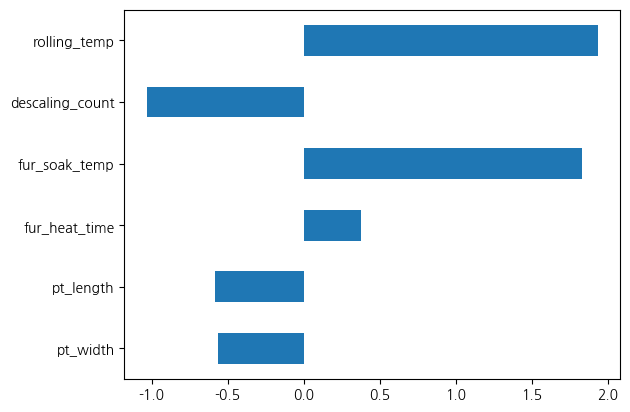

In [ ]:
# 설명변수 중요도
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = "Coef", legend = False)

#### 목표변수인 후판의 Scale 불량을 설명하는 변수 중:
- rolling_temp(압연 온도) > fur_soak_temp(가열로 균열대 소재온도) > fur_heat_time (가열로 가열대 재로시간) 순으로 영향력이 크다

## DecisionTree

In [ ]:
tree_uncust = DecisionTreeClassifier()
tree_uncust.fit(df_train_x_rd, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncust.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncust.score(df_test_x_rd, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.982


### max_depth

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경.
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [ ]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.923,0.909
1,2,0.962,0.947
2,3,0.968,0.954
3,4,0.968,0.954
4,5,0.991,0.986
5,6,0.991,0.986
6,7,0.995,0.986
7,8,0.997,0.982
8,9,0.998,0.982
9,10,1.000,0.986


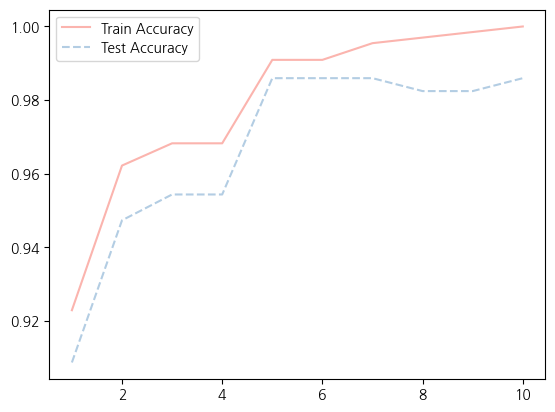

In [ ]:
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

max depth = 7

In [ ]:
v_feature_name = df_train_x_rd.columns

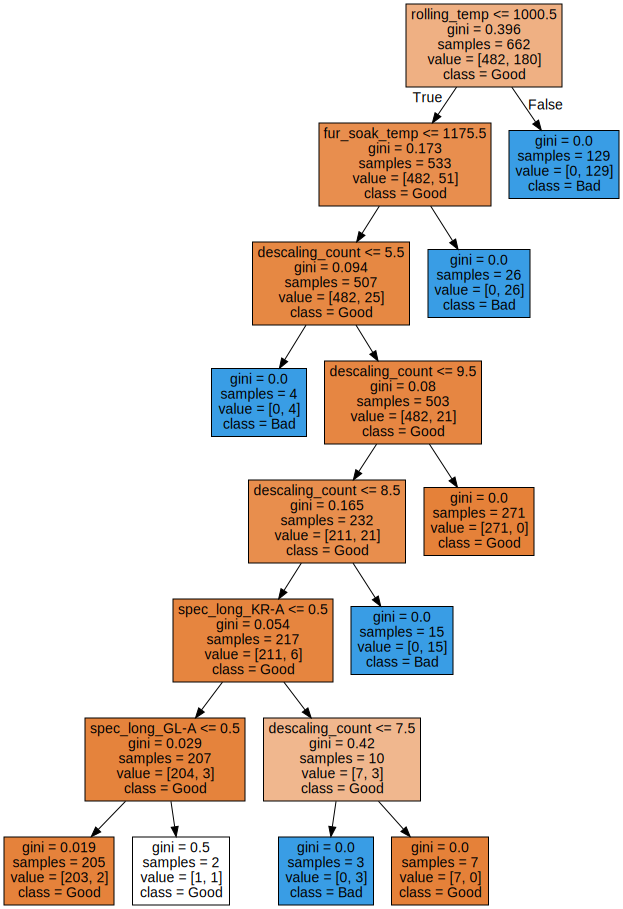

In [ ]:
tree_low = DecisionTreeClassifier(max_depth = 7)
tree_low.fit(df_train_x_rd, df_train_y)

# 트리 모델을 tree_low.dot 파일로 저장. (목표변수 레이블 지정(class_names):0-Good,1-Bad)
export_graphviz(tree_low, out_file="tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

# 트리 결과 시각화
with open("tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split

In [ ]:
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수
para_split = [n_split for n_split in range(2, 21)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth=7)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [ ]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.995,0.986
1,3,0.995,0.986
2,4,0.995,0.986
3,5,0.995,0.986
4,6,0.995,0.986
5,7,0.995,0.986
6,8,0.995,0.986
7,9,0.995,0.986
8,10,0.995,0.986
9,11,0.991,0.986


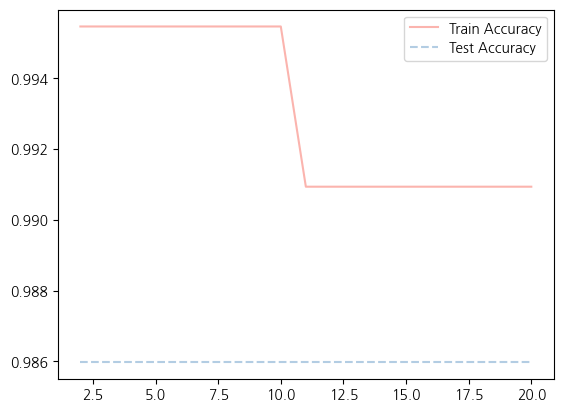

In [ ]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

test 정확도가 변하지 않으므로 선택하지 않음

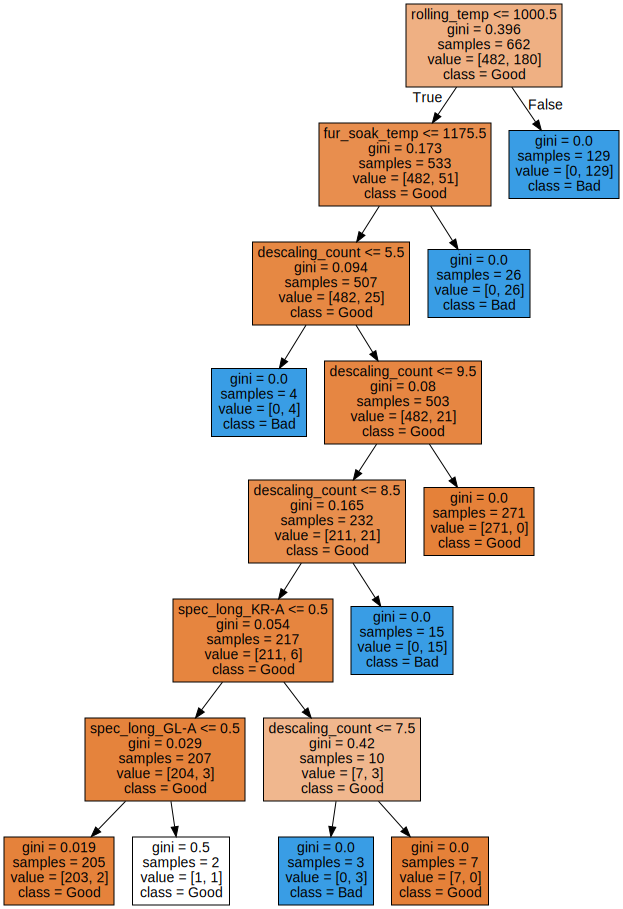

In [ ]:
tree_low = DecisionTreeClassifier(max_depth=7)
tree_low.fit(df_train_x_rd, df_train_y)

export_graphviz(tree_low, out_file="tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split

In [ ]:
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수.
para_leaf = [n_leaf for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, \
		max_depth=5)
    tree.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(tree.score(df_train_x_rd, df_train_y))
    test_accuracy.append(tree.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [ ]:
# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.991,0.986
1,2,0.991,0.986
2,3,0.991,0.986
3,4,0.991,0.986
4,5,0.985,0.979
5,6,0.985,0.979
6,7,0.985,0.979
7,8,0.985,0.979
8,9,0.985,0.979
9,10,0.985,0.979


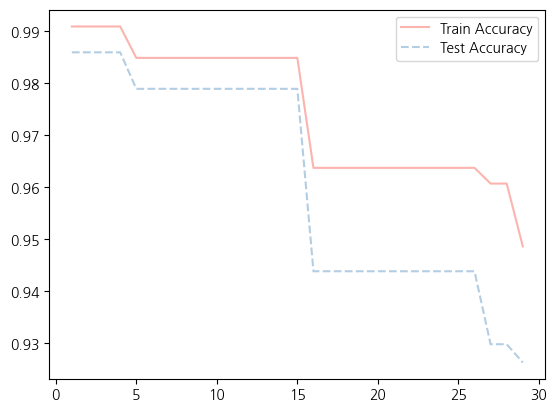

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

15로 선택

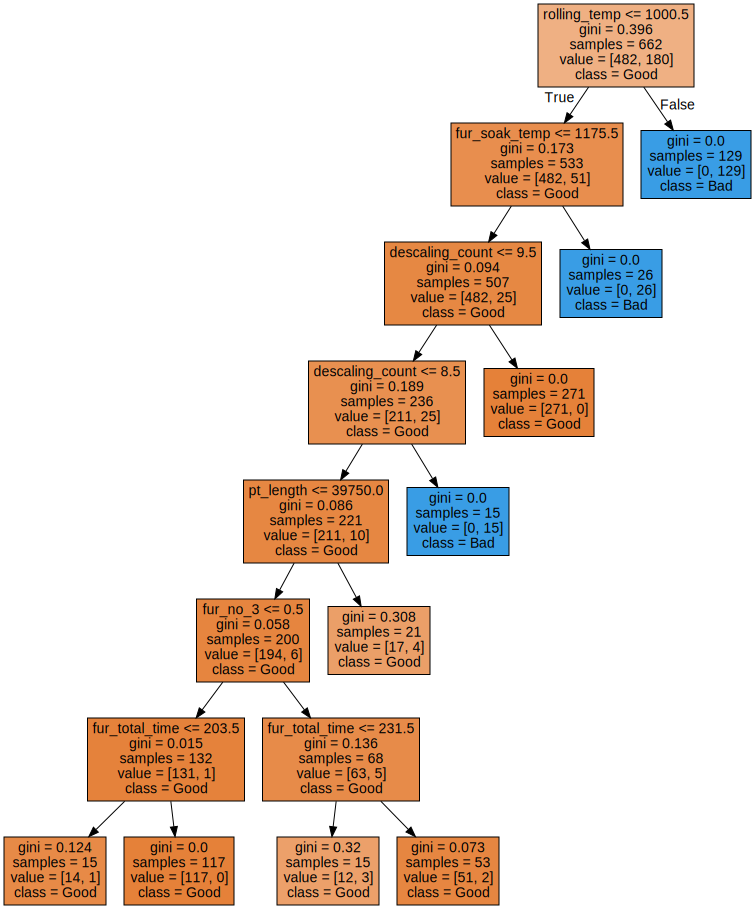

In [ ]:
# 잎사귀의 최소 자료 수가 인 모델
tree_low = DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)
tree_low.fit(df_train_x_rd, df_train_y)

export_graphviz(tree_low, out_file=" tree_low.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

with open(" tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### customed final model

In [ ]:
tree_final = DecisionTreeClassifier(max_depth=7, min_samples_split = 15)
tree_final.fit(df_train_x_rd, df_train_y)

DecisionTreeClassifier(max_depth=7, min_samples_split=15)

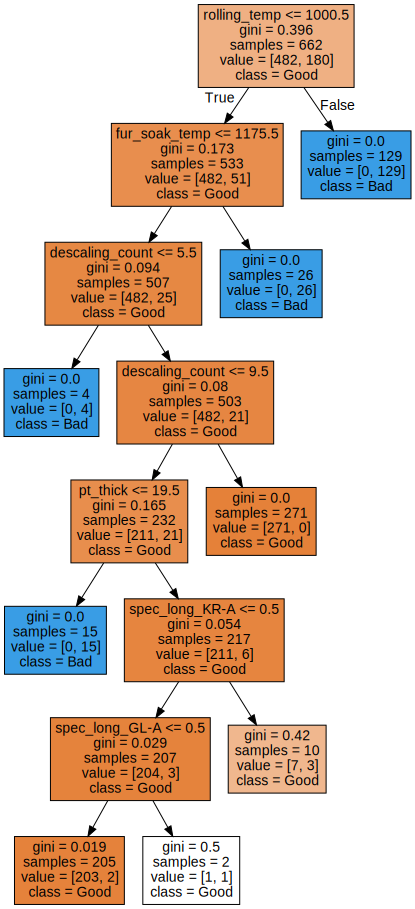

In [ ]:
# tree_final.dot으로 결과 저장
export_graphviz(tree_final, out_file="tree_final.dot", class_names = ["Good", "Bad"],
                feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [ ]:
# 평가
y_pred = tree_final.predict(df_test_x_rd)
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x_rd, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Test Accuracy: 0.986

Test Confusion matrix: 
[[202   0]
 [  4  79]]
              precision    recall  f1-score   support

           0      0.981     1.000     0.990       202
           1      1.000     0.952     0.975        83

    accuracy                          0.986       285
   macro avg      0.990     0.976     0.983       285
weighted avg      0.986     0.986     0.986       285



### feature importances(customed final model)

In [ ]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.672
5,fur_soak_temp,0.177
0,pt_thick,0.105
9,descaling_count,0.037
42,spec_long_KR-A,0.006
...,...,...
31,spec_long_GL-A32-TM,0.000
30,spec_long_GL-A32,0.000
28,spec_long_COMMON,0.000
27,spec_long_CCS-B,0.000


Text(0, 0.5, '설명변수')

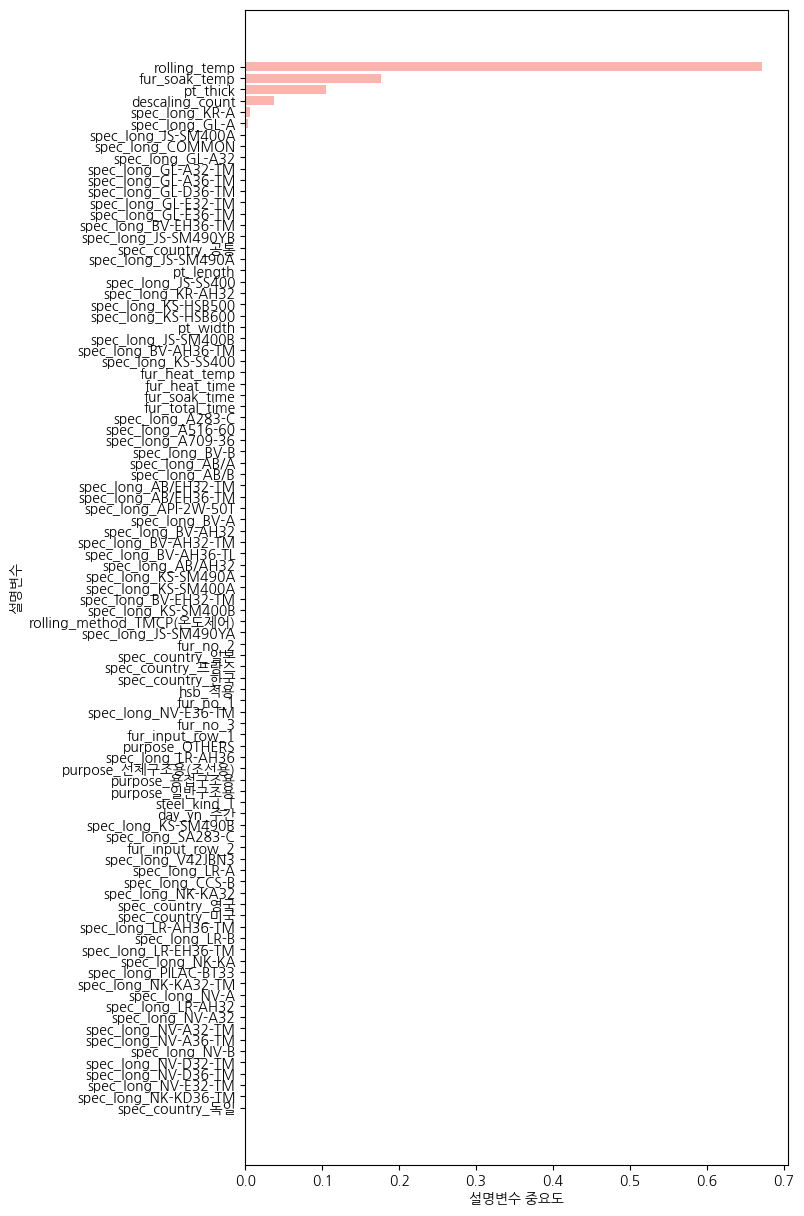

In [ ]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(7,15))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### GridSearch

In [ ]:
estimator = DecisionTreeClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth, "min_samples_split": para_split,
              "min_samples_leaf": para_leaf}
# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_dt.fit(df_train_x_rd, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))


best estimator model: 
DecisionTreeClassifier(max_depth=9, min_samples_split=3)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}

best score: 
0.983


In [ ]:
# 모델 적합
dt_grid_best = grid_dt.best_estimator_
dt_grid_best.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
dt_pred_train = dt_grid_best.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, dt_pred_train)
print('\n',classification_report(df_train_y, dt_pred_train))


# 예측 및 모델 평가:Test
dt_pred_test = dt_grid_best.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, dt_pred_test)
print('\n',classification_report(df_test_y, dt_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [  3 177]] 

정확도: 0.9955
정밀도: 1.0000
재현율: 0.9833
F1    : 0.9916
AUC   : 0.9917

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       482
           1       1.00      0.98      0.99       180

    accuracy                           1.00       662
   macro avg       1.00      0.99      0.99       662
weighted avg       1.00      1.00      1.00       662


 사용자 모델 평가 : Test 

오차행렬:
 [[202   0]
 [  4  79]] 

정확도: 0.9860
정밀도: 1.0000
재현율: 0.9518
F1    : 0.9753
AUC   : 0.9759

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       1.00      0.95      0.98        83

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



- grid search로 찾아낸 모델을 최종 모델로 선정

### Final model

In [ ]:
dt_final = grid_dt.best_estimator_
dt_grid_best.fit(df_train_x_rd, df_train_y)

DecisionTreeClassifier(max_depth=9, min_samples_split=3)

### feature importances(Fianl model)

In [ ]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = dt_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.656
5,fur_soak_temp,0.173
9,descaling_count,0.155
42,spec_long_KR-A,0.006
29,spec_long_GL-A,0.004
...,...,...
32,spec_long_GL-A36-TM,0.000
31,spec_long_GL-A32-TM,0.000
30,spec_long_GL-A32,0.000
28,spec_long_COMMON,0.000


Text(0, 0.5, '설명변수')

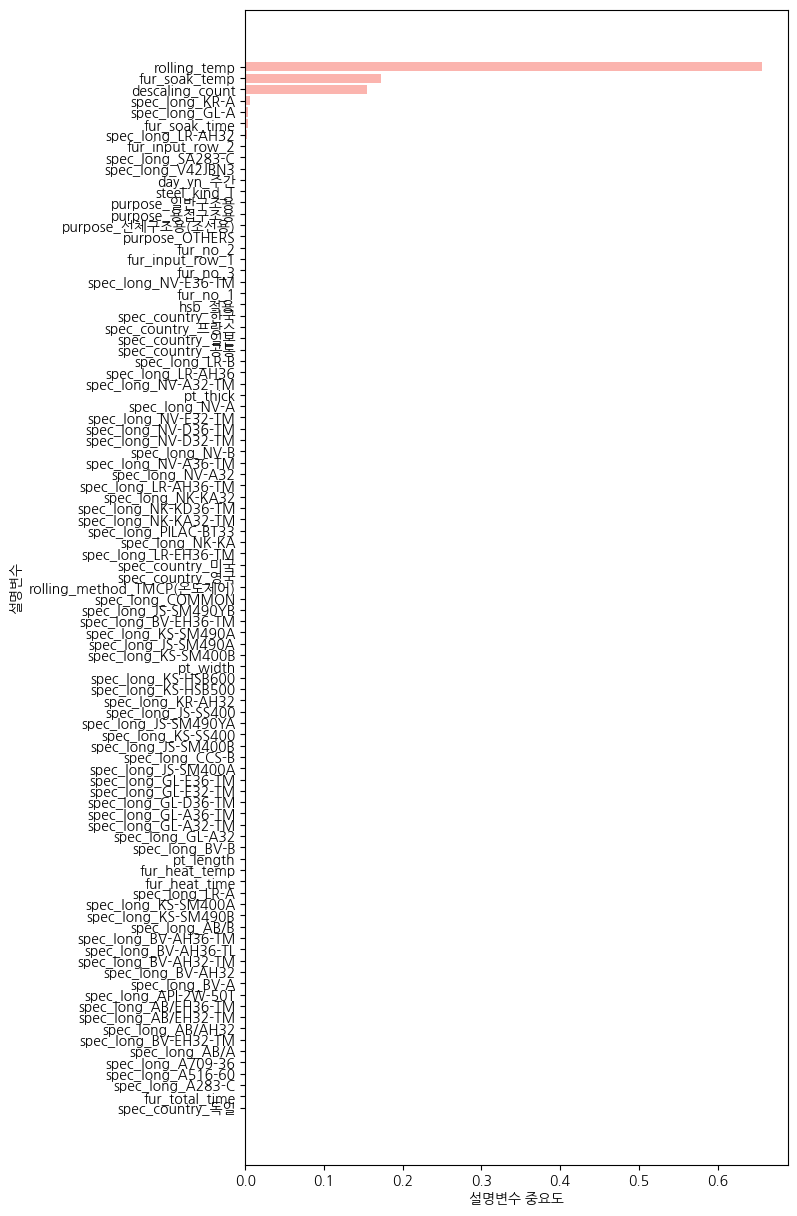

In [ ]:
# 설명변수 중요도 그래프
# sort_values : 중요도가 높은 변수를 상위에 그림.
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(7,15))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## RandomForest

### uncustomed model

In [ ]:
rf_uncust = RandomForestClassifier(random_state=2024)
rf_uncust.fit(df_train_x_rd, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x_rd, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.947


### n_estimators

In [ ]:
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [ ]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.995,0.940
1,20,0.998,0.944
2,30,1.000,0.944
3,40,1.000,0.944
4,50,1.000,0.944
5,60,1.000,0.944
6,70,1.000,0.944
7,80,1.000,0.944
8,90,1.000,0.944
9,100,1.000,0.944


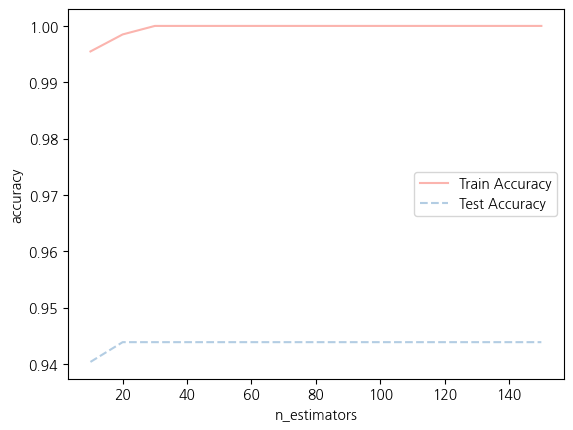

In [ ]:
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()

n_estimators = 20에서 Test accuracy가 제일 높고 Train set과 Test set의 차이가 가장 적으므로 n_estimators = 20으로 선정



In [ ]:
oob_error = []

for v_n_estimator in range(5, 121):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x_rd, df_train_y)
    oob_error.append(1 - rf.oob_score_)

Text(0.5, 0, 'n_estimators')

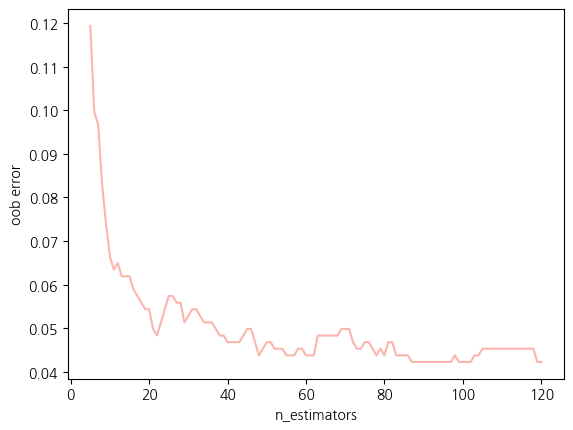

In [ ]:
plt.plot(range(5, 121), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

### max_depth

In [ ]:
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 16)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy


In [ ]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.734,0.712
1,2,0.888,0.867
2,3,0.926,0.912
3,4,0.940,0.930
4,5,0.946,0.933
5,6,0.958,0.937
6,7,0.970,0.940
7,8,0.973,0.937
8,9,0.977,0.937
9,10,0.991,0.944


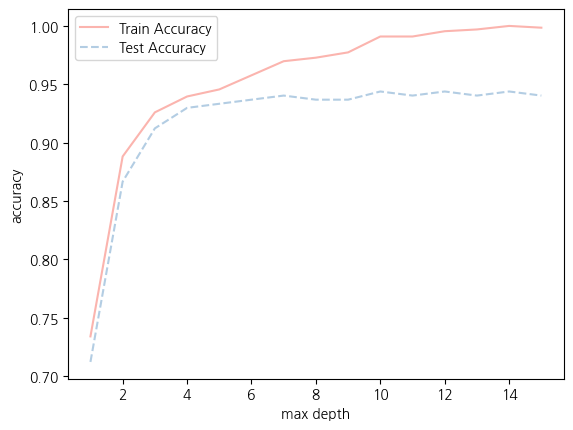

In [ ]:
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()

max_depth = 4 에서 Test accuracy가 최대이고 Train set과 Test set의 차이가 가장 적음. 그 중 최대값인 max_depth = 4 로 선정.

### min_samples_split

In [ ]:
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth=4,
                                n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [ ]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.938,0.926
1,20,0.934,0.926
2,30,0.927,0.916
3,40,0.929,0.916
4,50,0.924,0.916
5,60,0.921,0.912
6,70,0.920,0.912
7,80,0.920,0.912
8,90,0.921,0.912
9,100,0.917,0.912


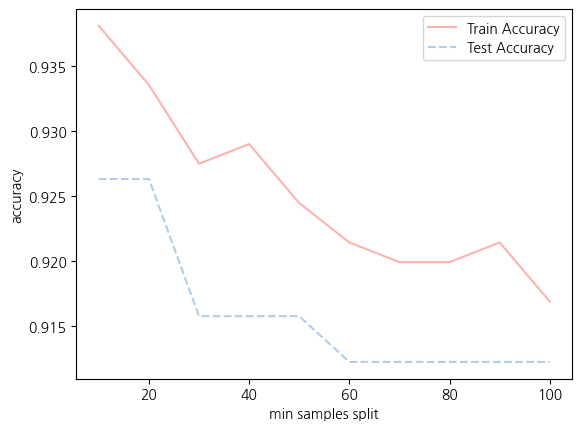

In [ ]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

한지수 부탁해요
min_samples_split 미지정

### min_samples_leaf

In [ ]:
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf  for n_leaf in range(1, 15)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,
                                max_depth=4, n_estimators=20, random_state=2024)
    rf.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(rf.score(df_train_x_rd, df_train_y))
    test_accuracy.append(rf.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [ ]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,0.940,0.930
1,2,0.938,0.926
2,3,0.937,0.926
3,4,0.941,0.930
4,5,0.938,0.926
5,6,0.940,0.926
6,7,0.938,0.930
7,8,0.938,0.926
8,9,0.937,0.930
9,10,0.934,0.926


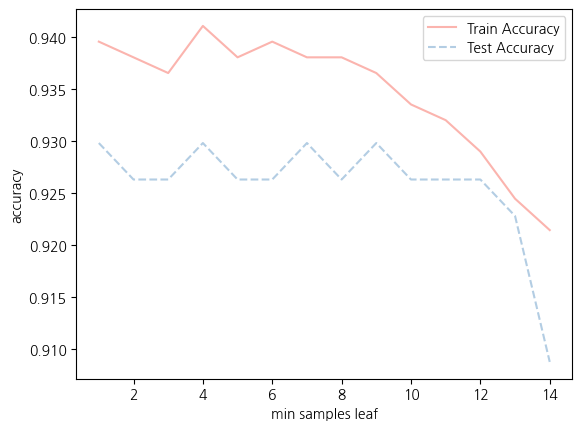

In [ ]:
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf"); plt.ylabel("accuracy")
plt.legend()

min_sample_leaf 8 Train set과 Test set의 차이가 가장 적은 min_sample_leaf = 8 선정

### customed final model

In [ ]:
rf_final = RandomForestClassifier(min_samples_leaf=8, max_depth=4, n_estimators=20,
                                  random_state=2024)
rf_final.fit(df_train_x_rd, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x_rd)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x_rd, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x_rd, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.938
Accuracy on test set: 0.926

Confusion matrix: 
[[202   0]
 [ 21  62]]
              precision    recall  f1-score   support

           0      0.906     1.000     0.951       202
           1      1.000     0.747     0.855        83

    accuracy                          0.926       285
   macro avg      0.953     0.873     0.903       285
weighted avg      0.933     0.926     0.923       285



min_sample_leaf = 8, max_depth = 4, n_estimators = 20

### feature importances

In [ ]:
v_feature_names = df_train_x_rd.columns
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
8,rolling_temp,0.339
5,fur_soak_temp,0.096
90,steel_kind_T,0.081
3,fur_heat_temp,0.075
1,pt_width,0.060
...,...,...
52,spec_long_LR-AH32,0.000
53,spec_long_LR-AH36,0.000
54,spec_long_LR-AH36-TM,0.000
18,spec_long_API-2W-50T,0.000


Text(0, 0.5, '설명변수')

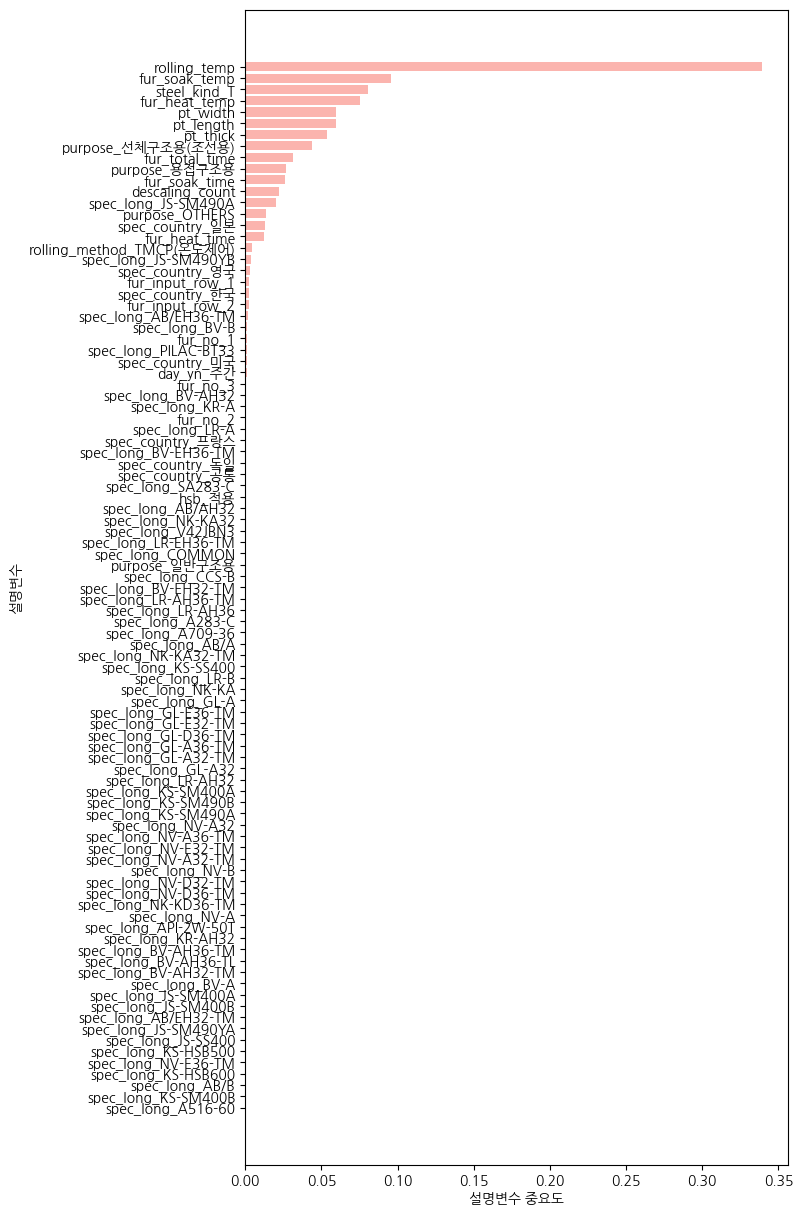

In [ ]:
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))

fig, axis = plt.subplots(figsize = (7,15))

plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### Grid Search

In [ ]:
estimator = RandomForestClassifier(n_estimators=20)
# 구하고자 하는 parameter와 범위
param_grid = {"max_depth": para_depth,
              "min_samples_leaf": para_leaf}
# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_rf.fit(df_train_x_rd, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))


best estimator model: 
RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=20)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 2}

best score: 
0.916


In [ ]:
# 모델 적합
rf_grid_best = grid_rf.best_estimator_
rf_grid_best.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
rf_pred_train = rf_grid_best.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, rf_pred_train)
print('\n',classification_report(df_train_y, rf_pred_train))


# 예측 및 모델 평가:Test
rf_pred_test = rf_grid_best.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, rf_pred_test)
print('\n',classification_report(df_test_y, rf_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [ 20 160]] 

정확도: 0.9698
정밀도: 1.0000
재현율: 0.8889
F1    : 0.9412
AUC   : 0.9444

               precision    recall  f1-score   support

           0       0.96      1.00      0.98       482
           1       1.00      0.89      0.94       180

    accuracy                           0.97       662
   macro avg       0.98      0.94      0.96       662
weighted avg       0.97      0.97      0.97       662


 사용자 모델 평가 : Test 

오차행렬:
 [[200   2]
 [ 15  68]] 

정확도: 0.9404
정밀도: 0.9714
재현율: 0.8193
F1    : 0.8889
AUC   : 0.9047

               precision    recall  f1-score   support

           0       0.93      0.99      0.96       202
           1       0.97      0.82      0.89        83

    accuracy                           0.94       285
   macro avg       0.95      0.90      0.92       285
weighted avg       0.94      0.94      0.94       285



- grid search로 찾은 모델을 final model로 선정
    - f1-score = 0.89로 직접 찾은 0.85보다 좋음.
    - test accuracy = 0.940로 직접 찾은 0.926보다 좋음.

### Final model

In [ ]:
# 최종 모델 이름 설정
rf_final = rf_grid_best
rf_final.fit(df_train_x_rd, df_train_y)

RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=20)

### feature importances(Final model)

In [ ]:
v_feature_names = df_train_x_rd.columns
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
8,rolling_temp,0.330
5,fur_soak_temp,0.094
1,pt_width,0.078
3,fur_heat_temp,0.075
9,descaling_count,0.069
...,...,...
66,spec_long_NV-D32-TM,0.000
65,spec_long_NV-B,0.000
64,spec_long_NV-A36-TM,0.000
45,spec_long_KS-HSB600,0.000


Text(0, 0.5, '설명변수')

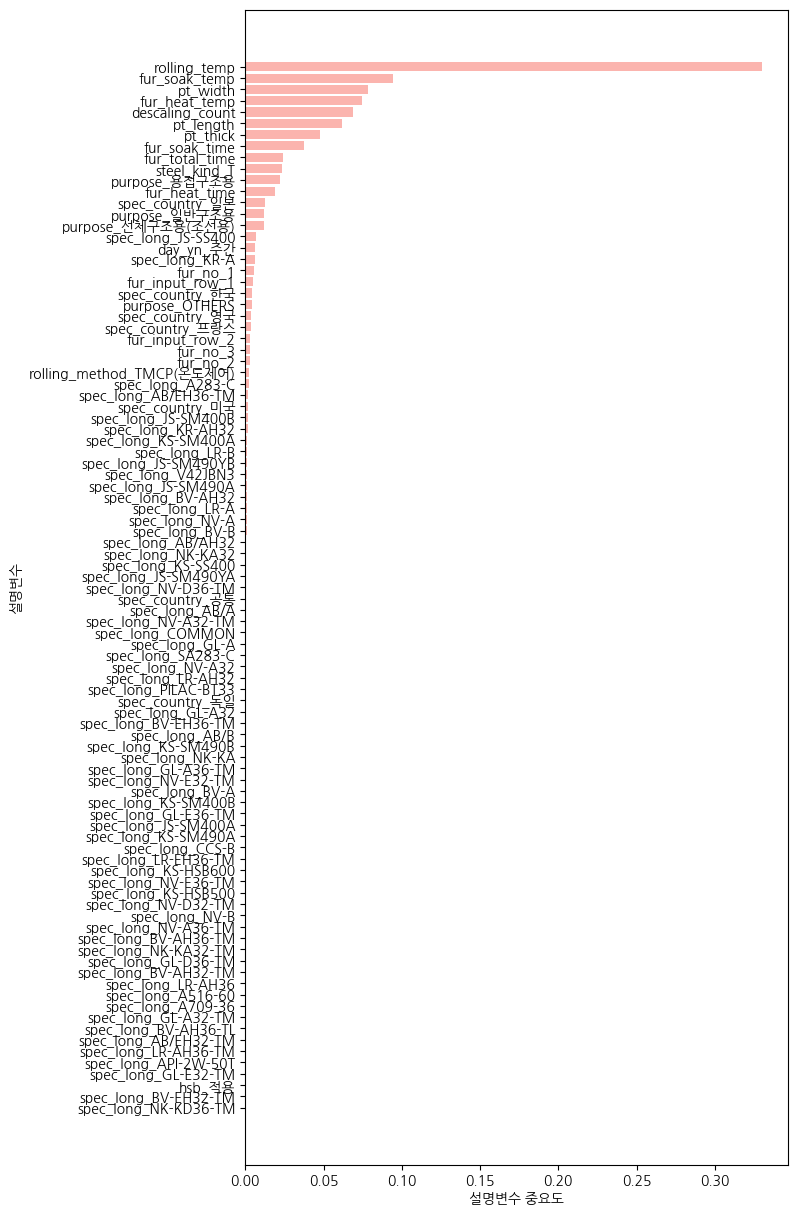

In [ ]:
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))

fig, axis = plt.subplots(figsize = (7,15))

plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## GradientBoosting

### uncustomed model

In [ ]:
rf_grid_best

RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=20)

In [ ]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier()
gb_uncust.fit(df_train_x_rd, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x_rd, df_test_y)))


Accuracy on training set: 1.000
Accuracy on test set: 0.982


### learning rate

In [ ]:

# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.02 for lr in range(1, 10)]
for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.02,0.968,0.954
1,0.04,0.995,0.975
2,0.06,1.000,0.979
3,0.08,1.000,0.989
4,0.10,1.000,0.982
5,0.12,1.000,0.989
6,0.14,1.000,0.989
7,0.16,1.000,0.989
8,0.18,1.000,0.993


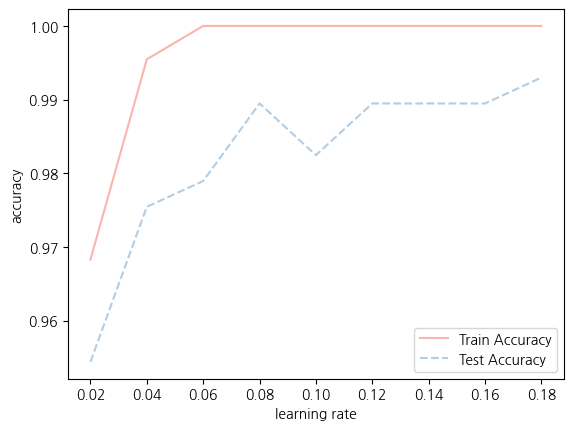

In [ ]:

# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

learning rate = 0.02  
0.02 이후로는 과적합 위험이 커지기 때문에 0.02로 선정.

### n_estimators

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.728,0.709
1,20,0.968,0.954
2,30,0.968,0.954
3,40,0.968,0.954
4,50,0.968,0.954
5,60,0.968,0.954
6,70,0.968,0.954
7,80,0.968,0.954
8,90,0.968,0.954
9,100,0.968,0.954


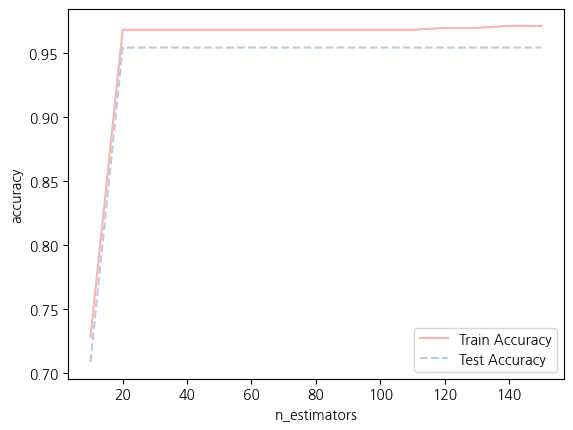

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

n_estimators = 20  

### max_depth

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                            n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# max_depth별 정확도
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.923,0.909
1,2,0.962,0.947
2,3,0.968,0.954
3,4,0.968,0.954
4,5,0.970,0.954
5,6,0.991,0.986
6,7,0.992,0.986
7,8,0.995,0.986
8,9,0.998,0.986
9,10,1.000,0.986


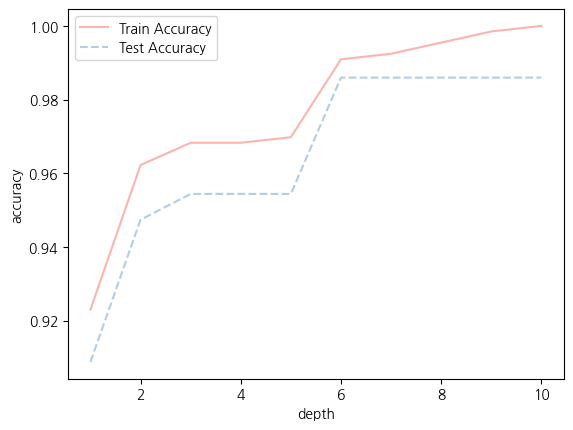

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

max depth = 6

### min_samples_split

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수. 20~100
para_split = [n_split * 10 for n_split in range(2, 5)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split,
                                    max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.991,0.986
1,30,0.991,0.986
2,40,0.991,0.986


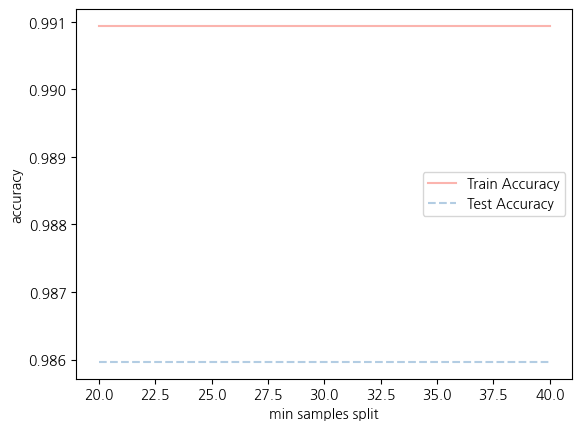

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

모델에 영향을 주지 않는 파라미터. 지정하지 않음

### min_samples_leaf

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 노드 최소 자료 수.
para_leaf = [n_leaf * 2 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth=6, n_estimators=20, learning_rate=0.02, random_state=1234)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.991,0.986
1,4,0.991,0.986
2,6,0.985,0.979
3,8,0.985,0.979
4,10,0.985,0.979
5,12,0.985,0.979
6,14,0.985,0.979
7,16,0.962,0.947
8,18,0.962,0.947
9,20,0.962,0.947


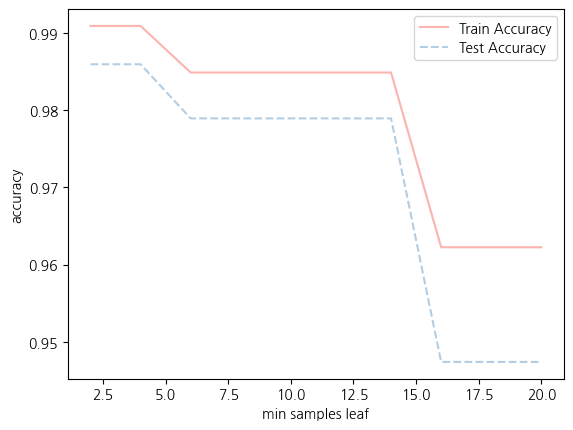

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

min_samples_leaf =4

### customed final model

In [ ]:
# 최종 모델
gb_final = GradientBoostingClassifier(max_depth=6, n_estimators=20, learning_rate=0.02, min_samples_leaf =4
                                      )
gb_final.fit(df_train_x_rd, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.991
Test Accuracy: 0.986

Test Confusion matrix: 
[[202   0]
 [  4  79]]
              precision    recall  f1-score   support

           0      0.981     1.000     0.990       202
           1      1.000     0.952     0.975        83

    accuracy                          0.986       285
   macro avg      0.990     0.976     0.983       285
weighted avg      0.986     0.986     0.986       285



### feature importances(customed final model)

In [ ]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
8,rolling_temp,0.674
5,fur_soak_temp,0.177
9,descaling_count,0.096
0,pt_thick,0.046
42,spec_long_KR-A,0.004
1,pt_width,0.003
2,pt_length,0.000
6,fur_soak_time,0.000
4,fur_heat_time,0.000
7,fur_total_time,0.000


Text(0, 0.5, '설명변수')

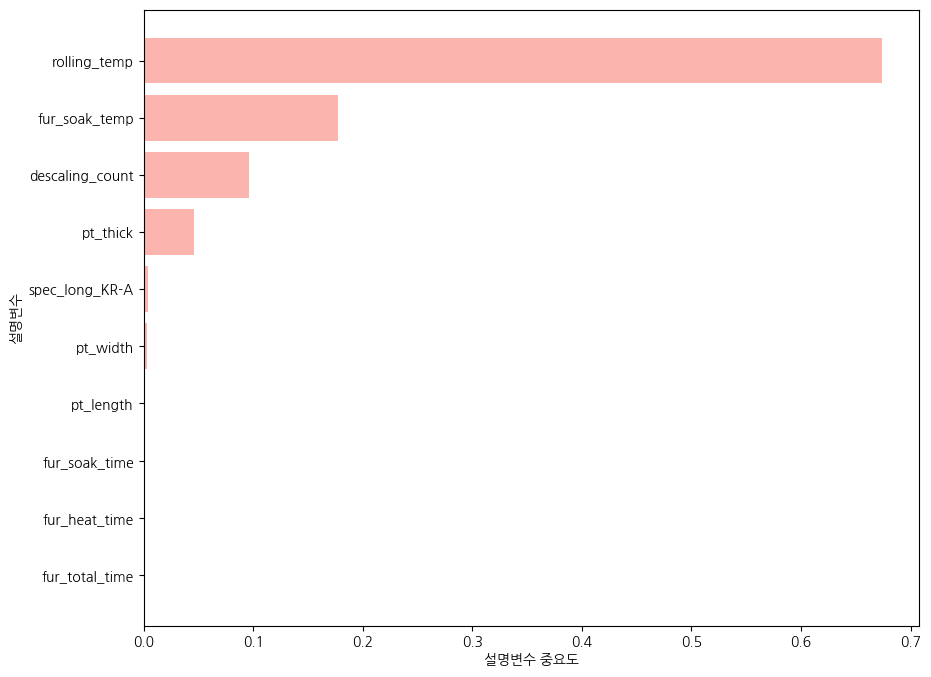

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위 10개 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance10 .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"])
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

rolling_temp, fur_soak_temp, descaling_count 순으로 중요하다.

### Grid Search

In [ ]:
estimator = GradientBoostingClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {"learning_rate": para_lr,
              "max_depth": para_depth,
              "min_samples_leaf": para_leaf,
              "n_estimators" : [50,100,150]}
# 정확도가 높은 최적 parameter 찾기
grid_gb = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_gb.fit(df_train_x_rd, df_train_y)
print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

In [ ]:
estimator = GradientBoostingClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {"learning_rate": para_lr,
              "max_depth": para_depth,
              "min_samples_leaf": para_leaf,
              "n_estimators" : [50,100,150]}
# 정확도가 높은 최적 parameter 찾기
grid_gb = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_gb.fit(df_train_x_rd, df_train_y)
print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

In [ ]:

y_pred = grid_gb.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(grid_gb.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(grid_gb.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Train Accuracy: 1.000
Test Accuracy: 0.994

Test Confusion matrix: 
[[202   0]
 [  1  82]]


### Final model

In [ ]:
# 최종 모델
gb_final = GradientBoostingClassifier(max_depth=5, n_estimators=100, learning_rate=0.18, min_samples_leaf =2
                                      )
gb_final.fit(df_train_x_rd, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x_rd)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x_rd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x_rd, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 1.000
Test Accuracy: 0.996

Test Confusion matrix: 
[[202   0]
 [  1  82]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       202
           1      1.000     0.988     0.994        83

    accuracy                          0.996       285
   macro avg      0.998     0.994     0.996       285
weighted avg      0.997     0.996     0.996       285



### feature importances(Final model)

In [ ]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance10 = df_importance.head(10)
df_importance10 .round(3)

,Feature,Importance
10,rolling_temp,0.648
7,fur_soak_temp,0.169
11,descaling_count,0.133
0,pt_thick,0.045
1,pt_width,0.003
2,pt_length,0.002
8,fur_soak_time,0.001
20,purpose_선체구조용(조선용),0.000
9,fur_total_time,0.000
16,spec_country_일본,0.000


/tmp/ipykernel_6937/609816765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_importance10 .sort_values("Importance", ascending=True, inplace = True)


Text(0, 0.5, '설명변수')

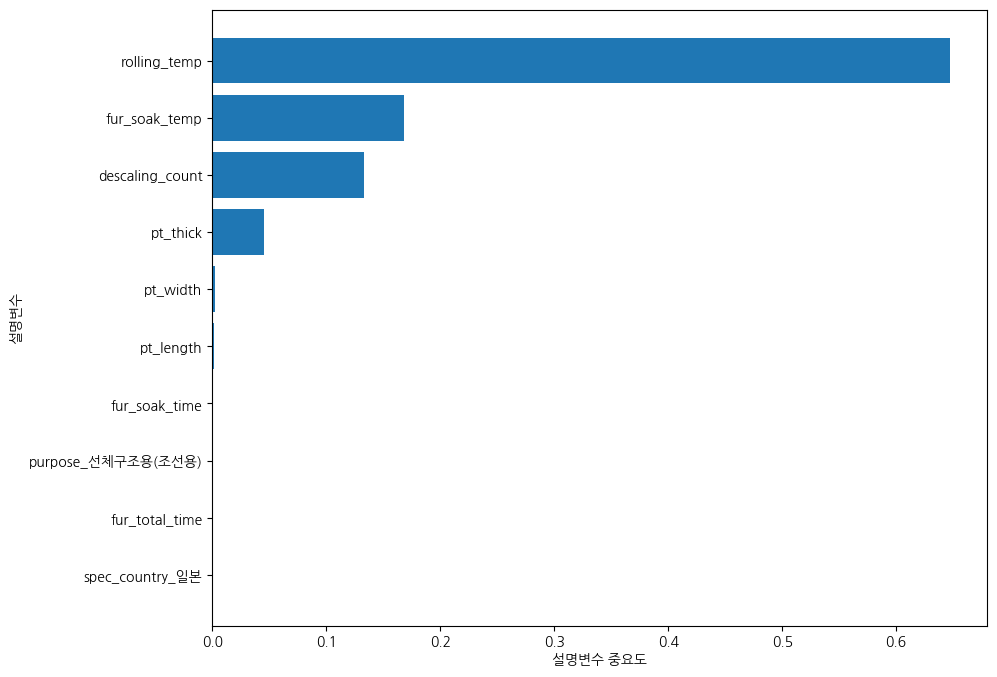

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위 10개 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance10 .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance10 ))
plt.barh(y = coordinates, width = df_importance10 ["Importance"])
plt.yticks(coordinates, df_importance10 ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## XGBoost

In [ ]:
# xgboost 패키지 불러오기
from xgboost import XGBClassifier

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

### uncustomed model

In [ ]:
# 기본 모델 지정 및 기본 옵션 확인
xgboost_uncust = XGBClassifier()
xgboost_uncust.fit(df_train_x_rd,df_train_y)
print('\n 모델 생성 및 평가 : Train \n')

# 예측 및 모델 평가:train
xgb_pred_train = xgboost_uncust.predict(df_train_x_rd)
# 모델 평가
eval_class_model(df_train_y, xgb_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
xgb_pred_test = xgboost_uncust.predict(df_test_x_rd)
# 모델 평가
eval_class_model(df_test_y, xgb_pred_test)


 모델 생성 및 평가 : Train 

오차행렬:
 [[482   0]
 [  0 180]] 

정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
F1    : 1.0000
AUC   : 1.0000

 모델 생성 및 평가 : Test 

오차행렬:
 [[202   0]
 [  3  80]] 

정확도: 0.9895
정밀도: 1.0000
재현율: 0.9639
F1    : 0.9816
AUC   : 0.9819


### learning_rate

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경
para_lr = [lr * 0.01 for lr in range(1, 10)]   # 민감하게 변화하면 0.02 간격으로 확인

for v_learning_rate in para_lr:
    gb = XGBClassifier(learning_rate = v_learning_rate)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [ ]:
# LearningRate별 정확도
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.01,0.985,0.979
1,0.02,0.992,0.979
2,0.03,0.994,0.982
3,0.04,0.994,0.986
4,0.05,0.994,0.986
5,0.06,0.995,0.986
6,0.07,0.997,0.986
7,0.08,0.997,0.986
8,0.09,0.998,0.986


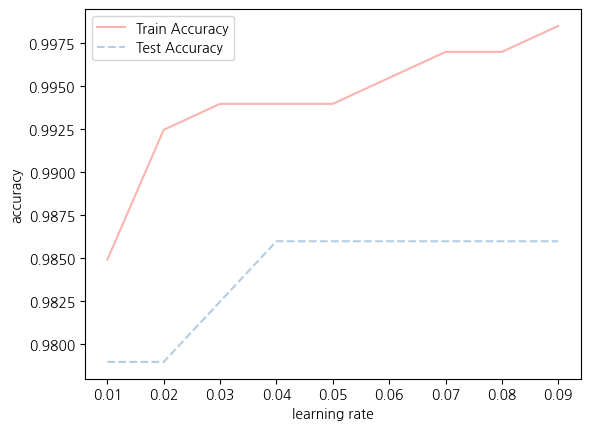

In [ ]:
# LearningRate별 정확도 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

- learning_rate = 0.04
    - train accuarcy와 test accuracy의 차이가 적고
    - test accuarcy가 떨어지기 전인 lr=0.03 선택

### n_estimators

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = XGBClassifier(n_estimators = v_n_estimators, learning_rate=0.04)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [ ]:
# n_estimators별 정확도
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.923,0.909
1,20,0.985,0.979
2,30,0.985,0.979
3,40,0.988,0.979
4,50,0.992,0.982
5,60,0.994,0.982
6,70,0.994,0.982
7,80,0.994,0.986
8,90,0.994,0.986
9,100,0.994,0.986


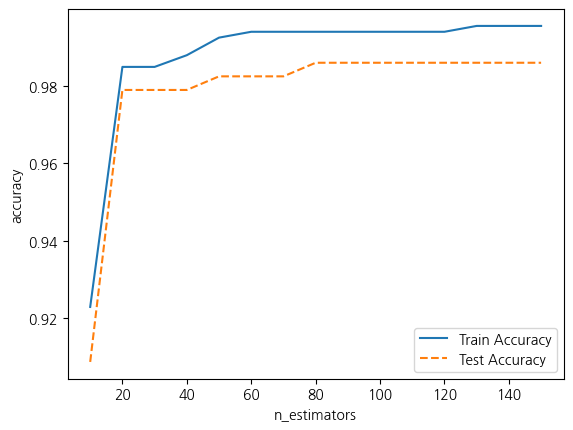

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

- n_estimators = 100
    - 20부터 120까지 train accuracy와 test accuracy가 비슷하지만
    - lr이 작으므로 적당히 큰 n_estimators = 100 선택

### max_depth

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경. 1~10
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = XGBClassifier(max_depth = v_max_depth,
                            n_estimators=100, learning_rate=0.04)
    gb.fit(df_train_x_rd, df_train_y)
    train_accuracy.append(gb.score(df_train_x_rd, df_train_y))
    test_accuracy.append(gb.score(df_test_x_rd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [ ]:
# max_depth별 정확도
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.962,0.947
1,2,0.962,0.947
2,3,0.986,0.968
3,4,0.992,0.986
4,5,0.994,0.986
5,6,0.994,0.986
6,7,0.994,0.986
7,8,0.994,0.986
8,9,0.994,0.986
9,10,0.994,0.986


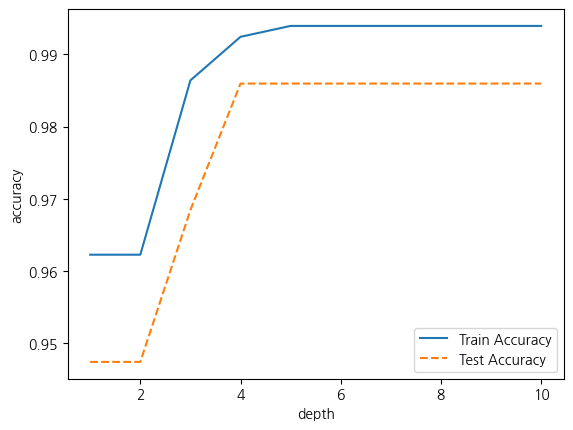

In [ ]:
# 정확도를 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

- max_depth = 5
    - max 값이므로 여유있게 max_depth = 5로 선택

### customed final model

In [ ]:
xgb_custom = XGBClassifier(max_depth = 5, n_estimators=100, learning_rate=0.04)

# 모델 적합
xgb_custom.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
xgb_pred_train = xgb_custom.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))


# 예측 및 모델 평가:Test
xgb_pred_test = xgb_custom.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [  4 176]] 

정확도: 0.9940
정밀도: 1.0000
재현율: 0.9778
F1    : 0.9888
AUC   : 0.9889

               precision    recall  f1-score   support

           0       0.99      1.00      1.00       482
           1       1.00      0.98      0.99       180

    accuracy                           0.99       662
   macro avg       1.00      0.99      0.99       662
weighted avg       0.99      0.99      0.99       662


 사용자 모델 평가 : Test 

오차행렬:
 [[202   0]
 [  4  79]] 

정확도: 0.9860
정밀도: 1.0000
재현율: 0.9518
F1    : 0.9753
AUC   : 0.9759

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       1.00      0.95      0.98        83

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



### Gris Search

In [ ]:
estimator = XGBClassifier()
# 구하고자 하는 parameter와 범위
param_grid = {"learning_rate": para_lr,
              "max_depth": para_depth,
              "n_estimators": [200, 250, 300],
              "gamma": [0, 1, 2]}
# 정확도가 높은 최적 parameter 찾기
grid_xgb = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs = -1)
grid_xgb.fit(df_train_x_rd, df_train_y)
print("best estimator model: \n{}".format(grid_xgb.best_estimator_))
print("\nbest parameter: \n{}".format(grid_xgb.best_params_))
print("\nbest score: \n{}".format(grid_xgb.best_score_.round(3)))

best estimator model: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

best parameter: 
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}

best score: 
0.98


In [ ]:
# 모델 적합
grid_best = grid_xgb.best_estimator_
grid_best.fit(df_train_x_rd, df_train_y)

# 예측 및 모델 평가:Train
xgb_pred_train = grid_best.predict(df_train_x_rd)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))


# 예측 및 모델 평가:Test
xgb_pred_test = grid_best.predict(df_test_x_rd)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))


 사용자 모델 평가 : Train 

오차행렬:
 [[482   0]
 [  2 178]] 

정확도: 0.9970
정밀도: 1.0000
재현율: 0.9889
F1    : 0.9944
AUC   : 0.9944

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       482
           1       1.00      0.99      0.99       180

    accuracy                           1.00       662
   macro avg       1.00      0.99      1.00       662
weighted avg       1.00      1.00      1.00       662


 사용자 모델 평가 : Test 

오차행렬:
 [[202   0]
 [  4  79]] 

정확도: 0.9860
정밀도: 1.0000
재현율: 0.9518
F1    : 0.9753
AUC   : 0.9759

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       1.00      0.95      0.98        83

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



- grid search 결과를 최종 모델로 선정
    - test set에 대한 f1-score와 accuracy는 비슷하지만
    - Cross Validatio을 거쳤으므로 더 안정성이 있다고 생각.

### Final model

In [ ]:
# 최종 모델 이름
xgb_final = grid_best
# best parameter:
# {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250}

### feature importances(Final model)

In [ ]:
# 변수명
v_feature_name = df_train_x_rd.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = xgb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
8,rolling_temp,0.434
5,fur_soak_temp,0.249
0,pt_thick,0.070
9,descaling_count,0.064
2,pt_length,0.030
7,fur_total_time,0.022
6,fur_soak_time,0.018
11,spec_country_독일,0.017
13,spec_country_영국,0.017
19,fur_no_3,0.015


Text(0, 0.5, '설명변수')

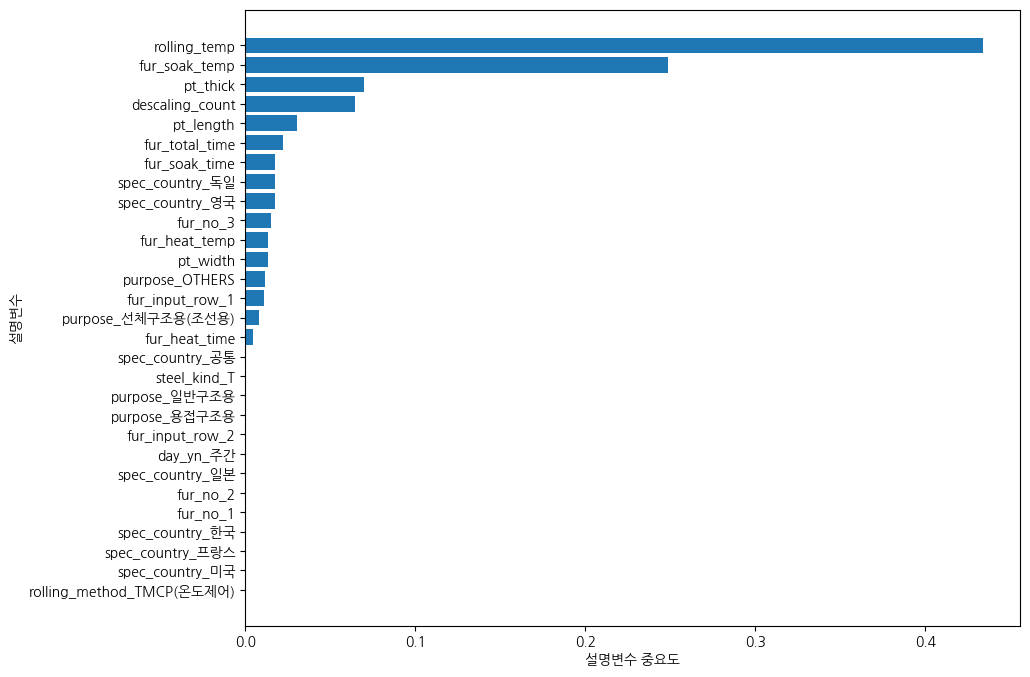

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## NN

### uncustomed model

In [179]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
nn_uncust = MLPClassifier()
nn_uncust.fit(df_train_x_sd, df_train_y)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(nn_uncust.score(df_train_x_sd, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}".format(nn_uncust.score(df_test_x_sd, df_test_y)))

Train Accuracy: 0.946
Test Accuracy: 0.888


### Hidden Layer

In [181]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
para_hidden = [5 * hidden for hidden in range(1, 21)]  # 은닉층 노드

print(para_hidden)

for v_hidden in para_hidden:
#     nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234) # 은닉층 : 1D (5,), (10,)...
    nn = MLPClassifier(hidden_layer_sizes = (v_hidden,v_hidden)) # 은닉층 : (10,10)...
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [182]:
# 은닉층별 정확도
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,5,0.906,0.874
1,10,0.914,0.874
2,15,0.905,0.860
3,20,0.955,0.891
4,25,0.959,0.860
5,30,0.965,0.888
6,35,0.988,0.895
7,40,0.992,0.902
8,45,0.989,0.877
9,50,0.994,0.898


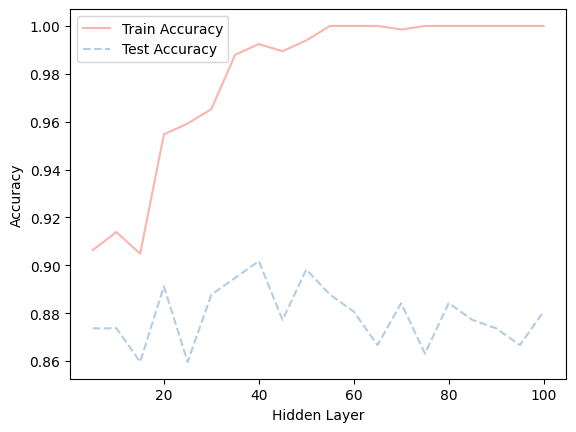

In [183]:
# 정확도 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

- Hidden Layer = 20 선택
    - 반복적으로 수행한 결과 hidden layer = 20에서 test accuracy가 꾸준히 높게 나오며
    - train accuracy와 test accuracy의 차이도 비교적 작아 overfitting 위험이 적다.

### Activation

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# activation 변경
para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function, hidden_layer_sizes=(20,20))
#     nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,100,60), random_state = 1234) # 변경 가능
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_function = pd.DataFrame()
df_accuracy_function["ActivationFunction"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

In [ ]:
# Activation Function별 정확도
df_accuracy_function.round(3)

,ActivationFunction,TrainAccuracy,TestAccuracy
0,logistic,0.879,0.856
1,tanh,0.937,0.881
2,relu,0.941,0.849


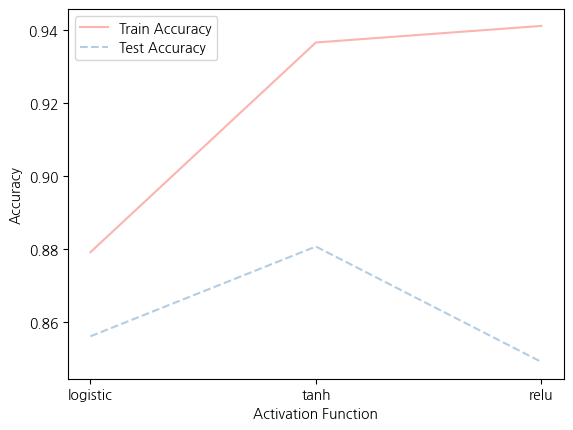

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Activation Function")
plt.legend()

- tanh의 test accuracy가 가장 높음

### Solver

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# solver 변경
para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver = v_solver, activation="tanh", hidden_layer_sizes=(20,20))
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy

In [ ]:
# Solver별 정확도 테이블
df_accuracy_solver.round(3)

,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,0.998,0.863
1,sgd,0.878,0.853
2,adam,0.937,0.877


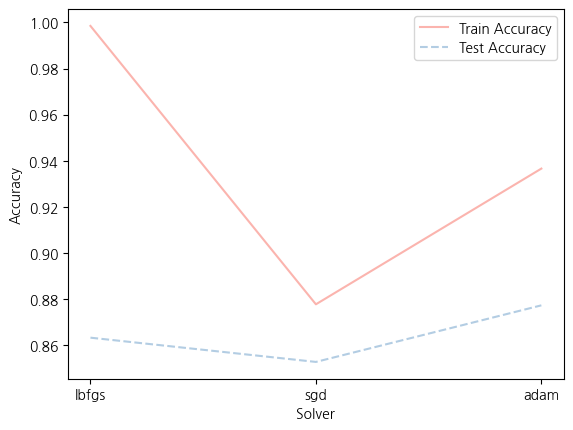

In [ ]:
# 정확도 그래프 확인
plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Solver")
plt.legend()

- Solver: adam 선택
    - test accuracy는 두번째이지만
    - overfitting 위험이 적은 adam을 선택한다.

### Mini Batch

In [ ]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# Mini Batch 변경
para_batch = [10 * batch for batch in range(1, 20)]

print(para_batch)

for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation = "tanh",
                       hidden_layer_sizes = (20,20))
    nn.fit(df_train_x_sd, df_train_y)
    train_accuracy.append(nn.score(df_train_x_sd, df_train_y))
    test_accuracy.append(nn.score(df_test_x_sd, df_test_y))

# 데이터 테이블로 저장
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Mini Batch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


In [ ]:
# Mini Batch 별 정확도
df_accuracy_batch.round(3)

,Mini Batch,TrainAccuracy,TestAccuracy
0,10,1.000,0.860
1,20,0.998,0.839
2,30,0.998,0.849
3,40,0.995,0.853
4,50,0.985,0.856
5,60,0.962,0.856
6,70,0.992,0.856
7,80,0.977,0.856
8,90,0.974,0.860
9,100,0.971,0.853


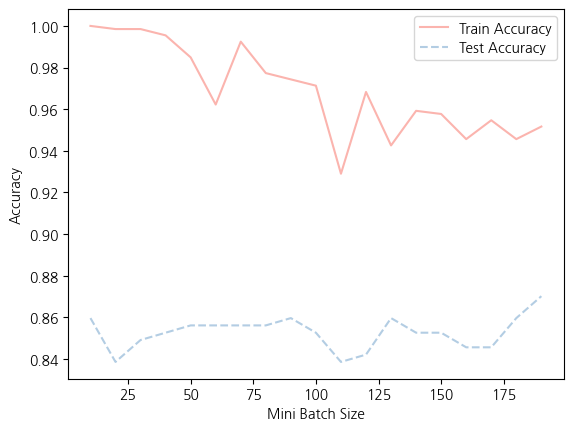

In [ ]:
# 모델 정확도 그래프 확인
plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Mini Batch Size")
plt.legend()

- Mini batch size 90으로 선택

### Final model

In [ ]:
nn_final = MLPClassifier(batch_size = 90, solver = "adam", activation = "tanh",
                       hidden_layer_sizes = (20,20))
nn_final.fit(df_train_x_sd, df_train_y)

# 평가
y_pred = nn_final.predict(df_test_x_sd)

# train 모델 정확도
print("Train Accucary : {:.3f}".format(nn_final.score(df_train_x_sd, df_train_y)))
# test 모델 정확도
print("Test Accuracy : {:.3f}\n".format(nn_final.score(df_test_x_sd, df_test_y)))
# confusion matrix
print("Test Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accucary : 0.967
Test Accuracy : 0.856

Test Confusion Matrix: 
[[187  15]
 [ 26  57]]
              precision    recall  f1-score   support

           0      0.878     0.926     0.901       202
           1      0.792     0.687     0.735        83

    accuracy                          0.856       285
   macro avg      0.835     0.806     0.818       285
weighted avg      0.853     0.856     0.853       285



- 개후짐

# important features 선택 및 모델 비교
    - 성능이 떨어지는 logistic regression과 nn 모델을 제외한 4가지 모델을 비교
    - decision tree: dt_final
    - random forest: rf_final
    - gradient boosting: gb_final
    - xgboost: xgb_final

- best 4 important features

|   | dt | rf | gb | xgb |
|---|---|---|---|---|
| 1  | rolling_temp  |  rolling_temp | rolling_temp  | rolling_temp  |
| 2  | fur_soak_temp  | fur_soak_temp  | fur_soak_temp  | fur_soak_temp  |
| 3  | descaling_count  | pt_width  | descaling_count  |  pt_thick |
| 4  | spec_long_KR-A  |  pt_thick |  fur_heat_temp |  descaling_count |

- 1, 2 순위는 4개 모델 모두에서 rolling_temp와 fur_soak_temp
- 3, 4순위는 descaling_count와 pt_thick
- pt_thick은 주문 받는 내역으로 조정이 불가능할 것이라 생각해 최종 변수에서 제외
- rolling_temp, fur_soak_temp, descaling_count를 최종 변수 3개로 선택

# 최종 모델 선정

## 성능

## 설명